In [132]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback
from sklearn.preprocessing import LabelEncoder
from PIL import Image 
import glob
import os

In [133]:
import os
import cv2
import numpy as np
import pandas as pd

# #Change this value based on your preferences
train_dir = "./jellyfish/Train_Test_Valid/Train"
train_dataframe = pd.DataFrame(columns=["path", "class"])

In [134]:
for class_name in os.listdir(train_dir):
  class_dir = os.path.join(train_dir, class_name)
  for image_name in os.listdir(class_dir):
    image_path = os.path.join(class_dir, image_name)
    train_dataframe.loc[len(train_dataframe.index)] = [image_path, class_name]

In [135]:
train_dataframe

,path,class
0,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
1,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
2,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
3,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
4,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
...,...,...
895,./jellyfish/Train_Test_Valid/Train/blue_jellyf...,blue_jellyfish
896,./jellyfish/Train_Test_Valid/Train/blue_jellyf...,blue_jellyfish
897,./jellyfish/Train_Test_Valid/Train/blue_jellyf...,blue_jellyfish
898,./jellyfish/Train_Test_Valid/Train/blue_jellyf...,blue_jellyfish


In [136]:
xdim = 224
ydim = 224

In [137]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

main_datagen=ImageDataGenerator(rescale=1./255., # 정규화 
                               horizontal_flip = True, # 수평으로 뒤집기
                                vertical_flip = True, # 수직으로 뒤집기 
                               rotation_range = 5) # +5도 또는 -5도 범위 내에서 회전 

In [138]:
# 데이터프레임의 "path"라는 열의 데이터를 NumPy 배열로 변환하여 X에 담기 
X = np.array(train_dataframe["path"])

In [139]:
wandb.login(key = "c4e33984a0f1d0c7e209f455add7b4da4718e070")

#import os
#import wandb

#wandb.login(key=os.getenv("WANDB_API_KEY"))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [140]:
sweep_config = {
    "name": "sweep_test_core",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

In [141]:
from sklearn.model_selection import KFold
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

def train_with_kfold():
    
    default_config = {
            #"input" : (28,28,1),
            #"filter" : 16,
            #"kernel" : (3,3),
            #"activation" : "relu",
            "learning_rate" : 0.005,
            #"optimizer" : "adam",
            #"loss" : "sparse_categorical_crossentropy",
            #"metrics" : ["accuracy"],
            "epoch" : 5,
            "batch_size" : 32
        }
    
    wandb.init(config = default_config)
    config = wandb.config
    
    
    kf = KFold(n_splits=5, random_state=1, shuffle=True)

    cvScores = []
    i = 1

    labels = list(train_dataframe["class"].unique())  # 고정된 클래스 레이블 사용

    for train_index, test_index in kf.split(X):
        print(f"Fold: {i} ==================================================================")
    
        # 폴드 내 훈련 및 테스트 데이터 설정
        train_data = X[train_index]
        test_data = X[test_index]
        train_dataframe_inside = train_dataframe.loc[train_dataframe["path"].isin(list(train_data))]
        validation_dataframe = train_dataframe.loc[train_dataframe["path"].isin(list(test_data))]
    
        # labels = list(train_dataframe_inside["class"].unique())
    
        if train_dataframe_inside.empty or validation_dataframe.empty:
            print(f"Empty data detected in fold {i}. Skipping.")
            continue
    
    
        # 데이터 제너레이터 설정
        train_generator = main_datagen.flow_from_dataframe(
            dataframe=train_dataframe_inside,
            #directory=None,
            x_col="path",
            y_col="class",
            class_mode="categorical",
            classes=labels,
            target_size=(xdim, ydim),
            color_mode="rgb",
            batch_size=32
        )
    
        validation_generator = main_datagen.flow_from_dataframe(
            dataframe=validation_dataframe,
            #directory=None,
            x_col="path",
            y_col="class",
            class_mode="categorical",
            classes=labels,
            target_size=(xdim, ydim),
            color_mode="rgb",
            batch_size=32
        )
    
        # 모델 정의
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(xdim, ydim, 3)),  # Input 레이어 추가
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.MaxPooling2D((4,4), padding='same'),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.MaxPooling2D((4,4), padding='same'),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.MaxPooling2D((4,4), padding='same'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            #tf.keras.layers.Dense(6, activation='softmax')
            tf.keras.layers.Dense(len(labels), activation='softmax')
        ])
    
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
    
        # 조기 종료 콜백 설정
        early_stopping = EarlyStopping(
            monitor='val_accuracy',         # 평가할 지표 (val_loss를 사용할 수도 있음)
            patience=10,                    # 10 에포크 동안 개선이 없으면 학습 중단
            restore_best_weights=True       # 가장 좋은 가중치를 복원
        )
    
    
    
         # W&B 설정
        wandb.init(
            project="WandB_with_kfold_used_by_Jindeok",
            name=f"fold-{i}",
            reinit=True  # 폴드별로 새 W&B 실행을 생성
        )
       
    
        # wandb.config 설정
        #wandb.config = {
            #"epoch": 10,  # 에포크 수
            #"batch_size": 32,  # 배치 크기
            #"learning_rate": 0.001  # 학습률
        #}
    
    
        # 모델 학습
        model_history = model.fit(
            train_generator,
            # epochs=config.epoch,
            epochs=wandb.config.epoch,
            validation_data=validation_generator,
            callbacks=[early_stopping, WandbCallback()]  # 조기 종료 콜백 추가, W&B 콜백 추가
        )
    
        # 학습 결과 시각화
        plt.figure(figsize=(10,5))
        plt.plot(model_history.history['accuracy'], label='Train Accuracy')
        plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0.5, 1])
        plt.legend(loc='lower right')
        plt.title(f'Fold {i} - Training and Validation Accuracy')
        plt.show()

        # 폴드 성능 평가
        scores = model.evaluate(validation_generator)
        cvScores.append(scores[1] * 100)
        print(f"Validation Accuracy for fold {i}: {scores[1] * 100:.2f}%")
    
        # i += 1
    
    
        # W&B 실행 종료
        wandb.finish()

        i += 1
    

Create sweep with ID: 4l3xqdfu
Sweep URL: https://wandb.ai/wisdom-jihyekim-aiffel/WandB_with_kfold_used_by_Jindeok/sweeps/4l3xqdfu


wandb: Agent Starting Run: l3vf5wy2 with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.014045245941277418


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 431ms/step - loss: 1.8500 - accuracy: 0.2486 - val_loss: 1.6776 - val_accuracy: 0.2889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_215919-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_215919-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 10s 416ms/step - loss: 1.5604 - accuracy: 0.3597 - val_loss: 1.5527 - val_accuracy: 0.4000
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_215919-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_215919-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 10s 410ms/step - loss: 1.3463 - accuracy: 0.4750 - val_loss: 1.3653 - val_accuracy: 0.4556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_215919-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_215919-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 9s 400ms/step - loss: 1.1936 - accuracy: 0.5278 - val_loss: 1.3384 - val_accuracy: 0.4611
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_215919-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_215919-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 5/7
23/23 [==============================] - 9s 402ms/step - loss: 1.1285 - accuracy: 0.5528 - val_loss: 1.1900 - val_accuracy: 0.5389
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_215919-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_215919-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 6/7
23/23 [==============================] - 10s 405ms/step - loss: 1.0144 - accuracy: 0.6056 - val_loss: 1.1865 - val_accuracy: 0.5333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_215919-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_215919-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 7/7
23/23 [==============================] - 9s 399ms/step - loss: 0.9370 - accuracy: 0.6458 - val_loss: 1.1533 - val_accuracy: 0.5667
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_215919-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_215919-l3vf5wy2/files/model-best)... Done. 0.0s


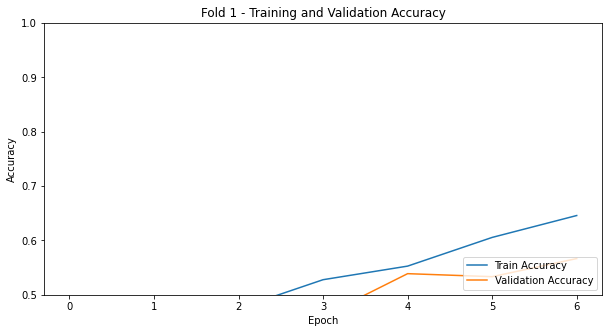

6/6 [==============================] - 2s 293ms/step - loss: 1.1933 - accuracy: 0.5167
Validation Accuracy for fold 1: 51.67%


accuracy,▁▃▅▆▆▇█
epoch,▁▂▃▅▆▇█
loss,█▆▄▃▂▂▁
val_accuracy,▁▄▅▅▇▇█
val_loss,█▆▄▃▁▁▁
accuracy,0.64583
best_epoch,6
best_val_loss,1.1533
epoch,6
loss,0.93703
val_accuracy,0.56667


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 2 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 426ms/step - loss: 1.8904 - accuracy: 0.2111 - val_loss: 1.7738 - val_accuracy: 0.2444
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220055-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220055-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 10s 409ms/step - loss: 1.6868 - accuracy: 0.3000 - val_loss: 1.6654 - val_accuracy: 0.2500
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220055-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220055-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 9s 415ms/step - loss: 1.5799 - accuracy: 0.3375 - val_loss: 1.5280 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220055-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220055-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 10s 411ms/step - loss: 1.3890 - accuracy: 0.4153 - val_loss: 1.3807 - val_accuracy: 0.4167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220055-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220055-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 5/7
23/23 [==============================] - 9s 403ms/step - loss: 1.3507 - accuracy: 0.4375 - val_loss: 1.4595 - val_accuracy: 0.3778
Epoch 6/7
23/23 [==============================] - 9s 404ms/step - loss: 1.1542 - accuracy: 0.5083 - val_loss: 1.2901 - val_accuracy: 0.4778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220055-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220055-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 7/7
23/23 [==============================] - 10s 408ms/step - loss: 1.0980 - accuracy: 0.5639 - val_loss: 1.2638 - val_accuracy: 0.5111
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220055-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220055-l3vf5wy2/files/model-best)... Done. 0.0s


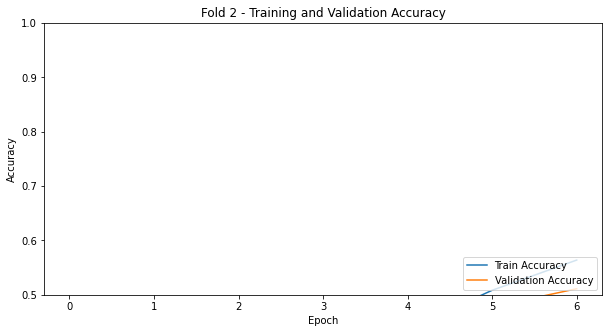

6/6 [==============================] - 2s 287ms/step - loss: 1.3088 - accuracy: 0.5222
Validation Accuracy for fold 2: 52.22%


accuracy,▁▃▄▅▅▇█
epoch,▁▂▃▅▆▇█
loss,█▆▅▄▃▁▁
val_accuracy,▁▁▃▆▄▇█
val_loss,█▇▅▃▄▁▁
accuracy,0.56389
best_epoch,6
best_val_loss,1.26377
epoch,6
loss,1.09798
val_accuracy,0.51111


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 3 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 423ms/step - loss: 1.8517 - accuracy: 0.2417 - val_loss: 1.5517 - val_accuracy: 0.3278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220222-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220222-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 9s 397ms/step - loss: 1.5184 - accuracy: 0.3597 - val_loss: 1.3316 - val_accuracy: 0.4722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220222-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220222-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 9s 403ms/step - loss: 1.3467 - accuracy: 0.4514 - val_loss: 1.3098 - val_accuracy: 0.4556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220222-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220222-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 10s 406ms/step - loss: 1.2667 - accuracy: 0.4847 - val_loss: 1.2588 - val_accuracy: 0.5167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220222-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220222-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 5/7
23/23 [==============================] - 10s 411ms/step - loss: 1.1658 - accuracy: 0.5333 - val_loss: 1.0919 - val_accuracy: 0.5111
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220222-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220222-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 6/7
23/23 [==============================] - 9s 400ms/step - loss: 1.1162 - accuracy: 0.5653 - val_loss: 1.1213 - val_accuracy: 0.5778
Epoch 7/7
23/23 [==============================] - 9s 400ms/step - loss: 1.0389 - accuracy: 0.6042 - val_loss: 1.0709 - val_accuracy: 0.5500
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220222-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220222-l3vf5wy2/files/model-best)... Done. 0.0s


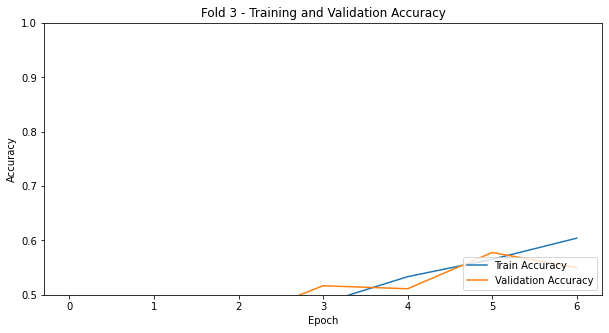

6/6 [==============================] - 2s 288ms/step - loss: 1.0862 - accuracy: 0.5333
Validation Accuracy for fold 3: 53.33%


accuracy,▁▃▅▆▇▇█
epoch,▁▂▃▅▆▇█
loss,█▅▄▃▂▂▁
val_accuracy,▁▅▅▆▆█▇
val_loss,█▅▄▄▁▂▁
accuracy,0.60417
best_epoch,6
best_val_loss,1.07087
epoch,6
loss,1.03893
val_accuracy,0.55


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 4 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 430ms/step - loss: 1.9245 - accuracy: 0.2708 - val_loss: 1.6471 - val_accuracy: 0.3222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220352-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220352-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 10s 407ms/step - loss: 1.5873 - accuracy: 0.3417 - val_loss: 1.5547 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220352-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220352-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 9s 400ms/step - loss: 1.4164 - accuracy: 0.4097 - val_loss: 1.6957 - val_accuracy: 0.3444
Epoch 4/7
23/23 [==============================] - 9s 405ms/step - loss: 1.3832 - accuracy: 0.4222 - val_loss: 1.3415 - val_accuracy: 0.4778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220352-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220352-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 5/7
23/23 [==============================] - 10s 408ms/step - loss: 1.1713 - accuracy: 0.5472 - val_loss: 1.3431 - val_accuracy: 0.4667
Epoch 6/7
23/23 [==============================] - 10s 428ms/step - loss: 1.1144 - accuracy: 0.5972 - val_loss: 1.2286 - val_accuracy: 0.5278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220352-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220352-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 7/7
23/23 [==============================] - 9s 405ms/step - loss: 1.1356 - accuracy: 0.5819 - val_loss: 1.1886 - val_accuracy: 0.5278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220352-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220352-l3vf5wy2/files/model-best)... Done. 0.0s


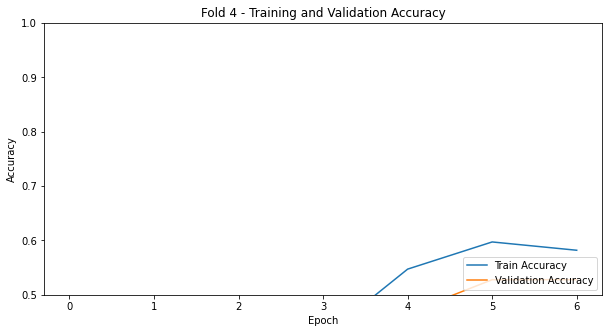

6/6 [==============================] - 2s 284ms/step - loss: 1.1873 - accuracy: 0.5056
Validation Accuracy for fold 4: 50.56%


accuracy,▁▃▄▄▇██
epoch,▁▂▃▅▆▇█
loss,█▅▄▃▁▁▁
val_accuracy,▁▁▂▆▆██
val_loss,▇▆█▃▃▂▁
accuracy,0.58194
best_epoch,6
best_val_loss,1.18858
epoch,6
loss,1.13559
val_accuracy,0.52778


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 5 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 427ms/step - loss: 1.8205 - accuracy: 0.2847 - val_loss: 1.5649 - val_accuracy: 0.3278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220519-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220519-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 10s 406ms/step - loss: 1.4884 - accuracy: 0.3750 - val_loss: 1.4143 - val_accuracy: 0.4389
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220519-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220519-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 9s 406ms/step - loss: 1.3586 - accuracy: 0.4361 - val_loss: 1.3612 - val_accuracy: 0.4833
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220519-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220519-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 10s 416ms/step - loss: 1.2145 - accuracy: 0.5222 - val_loss: 1.2316 - val_accuracy: 0.5222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220519-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220519-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 5/7
23/23 [==============================] - 10s 407ms/step - loss: 1.1471 - accuracy: 0.5389 - val_loss: 1.1801 - val_accuracy: 0.5444
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220519-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220519-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 6/7
23/23 [==============================] - 10s 409ms/step - loss: 1.0388 - accuracy: 0.6153 - val_loss: 1.0982 - val_accuracy: 0.5944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220519-l3vf5wy2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220519-l3vf5wy2/files/model-best)... Done. 0.0s


Epoch 7/7
23/23 [==============================] - 10s 428ms/step - loss: 0.9320 - accuracy: 0.6194 - val_loss: 1.2763 - val_accuracy: 0.5278


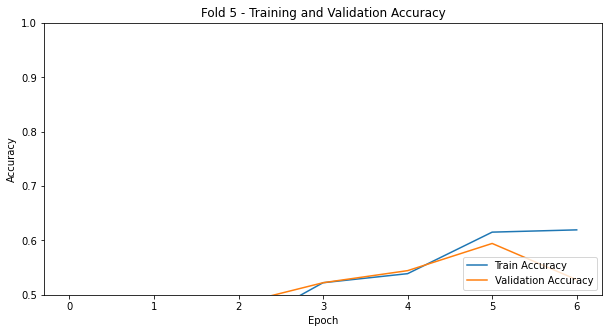

6/6 [==============================] - 2s 289ms/step - loss: 1.2414 - accuracy: 0.5278
Validation Accuracy for fold 5: 52.78%


accuracy,▁▃▄▆▆██
epoch,▁▂▃▅▆▇█
loss,█▅▄▃▃▂▁
val_accuracy,▁▄▅▆▇█▆
val_loss,█▆▅▃▂▁▄
accuracy,0.61944
best_epoch,5
best_val_loss,1.0982
epoch,6
loss,0.93204
val_accuracy,0.52778


wandb: Agent Starting Run: 0x0f6cyy with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.016863280515777485


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/8
23/23 [==============================] - 11s 431ms/step - loss: 1.9589 - accuracy: 0.2431 - val_loss: 1.7077 - val_accuracy: 0.2389
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220651-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220651-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 2/8
23/23 [==============================] - 10s 416ms/step - loss: 1.6422 - accuracy: 0.2917 - val_loss: 1.6415 - val_accuracy: 0.2944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220651-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220651-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 3/8
23/23 [==============================] - 10s 407ms/step - loss: 1.5130 - accuracy: 0.3611 - val_loss: 1.5437 - val_accuracy: 0.3111
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220651-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220651-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 4/8
23/23 [==============================] - 9s 402ms/step - loss: 1.3752 - accuracy: 0.4472 - val_loss: 1.4367 - val_accuracy: 0.4222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220651-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220651-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 5/8
23/23 [==============================] - 10s 409ms/step - loss: 1.2933 - accuracy: 0.4653 - val_loss: 1.3792 - val_accuracy: 0.3778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220651-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220651-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 6/8
23/23 [==============================] - 10s 407ms/step - loss: 1.2532 - accuracy: 0.4903 - val_loss: 1.3271 - val_accuracy: 0.4556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220651-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220651-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 7/8
23/23 [==============================] - 9s 401ms/step - loss: 1.2157 - accuracy: 0.5222 - val_loss: 1.2017 - val_accuracy: 0.4722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220651-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220651-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 8/8
23/23 [==============================] - 10s 409ms/step - loss: 1.0203 - accuracy: 0.5944 - val_loss: 1.2307 - val_accuracy: 0.5222


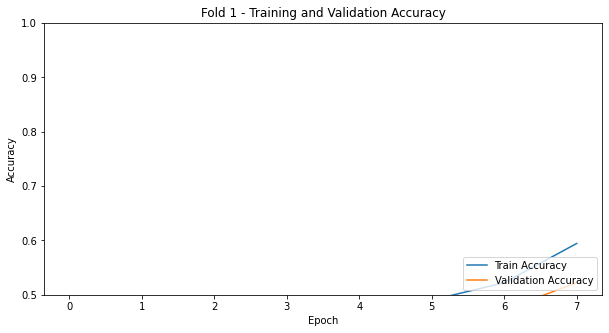

6/6 [==============================] - 2s 294ms/step - loss: 1.2030 - accuracy: 0.5333
Validation Accuracy for fold 1: 53.33%


accuracy,▁▂▃▅▅▆▇█
epoch,▁▂▃▄▅▆▇█
loss,█▆▅▄▃▃▂▁
val_accuracy,▁▂▃▆▄▆▇█
val_loss,█▇▆▄▃▃▁▁
accuracy,0.59444
best_epoch,6
best_val_loss,1.20172
epoch,7
loss,1.02034
val_accuracy,0.52222


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 2 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/8
23/23 [==============================] - 11s 438ms/step - loss: 1.8919 - accuracy: 0.2389 - val_loss: 1.7393 - val_accuracy: 0.2889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220835-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220835-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 2/8
23/23 [==============================] - 10s 407ms/step - loss: 1.6081 - accuracy: 0.3569 - val_loss: 1.5868 - val_accuracy: 0.3278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220835-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220835-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 3/8
23/23 [==============================] - 9s 403ms/step - loss: 1.4214 - accuracy: 0.3819 - val_loss: 1.4423 - val_accuracy: 0.4722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220835-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220835-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 4/8
23/23 [==============================] - 10s 426ms/step - loss: 1.2843 - accuracy: 0.4972 - val_loss: 1.3604 - val_accuracy: 0.4667
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220835-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220835-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 5/8
23/23 [==============================] - 10s 415ms/step - loss: 1.1912 - accuracy: 0.5056 - val_loss: 1.4145 - val_accuracy: 0.4278
Epoch 6/8
23/23 [==============================] - 9s 409ms/step - loss: 1.1938 - accuracy: 0.5181 - val_loss: 1.4050 - val_accuracy: 0.4111
Epoch 7/8
23/23 [==============================] - 9s 407ms/step - loss: 1.0264 - accuracy: 0.5847 - val_loss: 1.1804 - val_accuracy: 0.5722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_220835-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_220835-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 8/8
23/23 [==============================] - 10s 412ms/step - loss: 0.9784 - accuracy: 0.6097 - val_loss: 1.3179 - val_accuracy: 0.5111


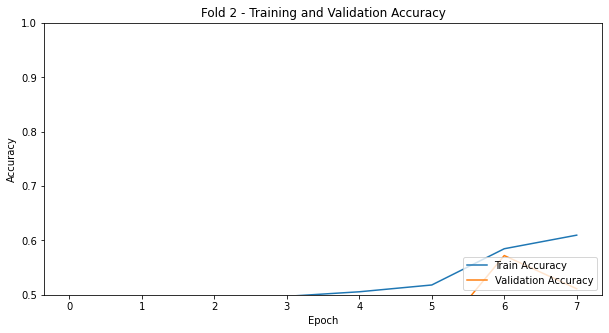

6/6 [==============================] - 2s 305ms/step - loss: 1.3244 - accuracy: 0.5111
Validation Accuracy for fold 2: 51.11%


accuracy,▁▃▄▆▆▆██
epoch,▁▂▃▄▅▆▇█
loss,█▆▄▃▃▃▁▁
val_accuracy,▁▂▆▅▄▄█▆
val_loss,█▆▄▃▄▄▁▃
accuracy,0.60972
best_epoch,6
best_val_loss,1.1804
epoch,7
loss,0.97838
val_accuracy,0.51111


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 3 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/8
23/23 [==============================] - 11s 443ms/step - loss: 1.8520 - accuracy: 0.2403 - val_loss: 1.7248 - val_accuracy: 0.2833
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221013-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221013-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 2/8
23/23 [==============================] - 10s 415ms/step - loss: 1.6229 - accuracy: 0.3375 - val_loss: 1.3967 - val_accuracy: 0.4611
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221013-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221013-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 3/8
23/23 [==============================] - 10s 417ms/step - loss: 1.4231 - accuracy: 0.4194 - val_loss: 1.2436 - val_accuracy: 0.5222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221013-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221013-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 4/8
23/23 [==============================] - 10s 426ms/step - loss: 1.3338 - accuracy: 0.4569 - val_loss: 1.2503 - val_accuracy: 0.4889
Epoch 5/8
23/23 [==============================] - 10s 423ms/step - loss: 1.2627 - accuracy: 0.4944 - val_loss: 1.2128 - val_accuracy: 0.5000
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221013-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221013-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 6/8
23/23 [==============================] - 10s 428ms/step - loss: 1.1654 - accuracy: 0.5347 - val_loss: 1.1148 - val_accuracy: 0.5444
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221013-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221013-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 7/8
23/23 [==============================] - 10s 421ms/step - loss: 1.1114 - accuracy: 0.5389 - val_loss: 1.0778 - val_accuracy: 0.5556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221013-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221013-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 8/8
23/23 [==============================] - 10s 423ms/step - loss: 1.0362 - accuracy: 0.6042 - val_loss: 1.1269 - val_accuracy: 0.5556


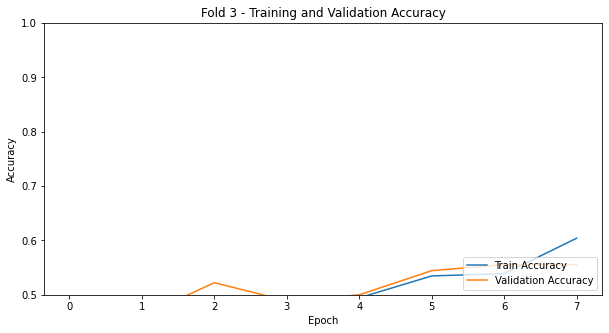

6/6 [==============================] - 2s 293ms/step - loss: 1.0806 - accuracy: 0.5722
Validation Accuracy for fold 3: 57.22%


accuracy,▁▃▄▅▆▇▇█
epoch,▁▂▃▄▅▆▇█
loss,█▆▄▄▃▂▂▁
val_accuracy,▁▆▇▆▇███
val_loss,█▄▃▃▂▁▁▂
accuracy,0.60417
best_epoch,6
best_val_loss,1.07782
epoch,7
loss,1.03623
val_accuracy,0.55556


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 4 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/8
23/23 [==============================] - 11s 434ms/step - loss: 1.8088 - accuracy: 0.2417 - val_loss: 1.6462 - val_accuracy: 0.3222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221153-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221153-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 2/8
23/23 [==============================] - 9s 401ms/step - loss: 1.5711 - accuracy: 0.3389 - val_loss: 1.4686 - val_accuracy: 0.3944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221153-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221153-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 3/8
23/23 [==============================] - 9s 409ms/step - loss: 1.4242 - accuracy: 0.4236 - val_loss: 1.3411 - val_accuracy: 0.4111
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221153-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221153-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 4/8
23/23 [==============================] - 10s 407ms/step - loss: 1.3628 - accuracy: 0.4500 - val_loss: 1.4469 - val_accuracy: 0.4333
Epoch 5/8
23/23 [==============================] - 9s 408ms/step - loss: 1.3341 - accuracy: 0.4958 - val_loss: 1.3044 - val_accuracy: 0.5111
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221153-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221153-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 6/8
23/23 [==============================] - 10s 406ms/step - loss: 1.2108 - accuracy: 0.5250 - val_loss: 1.1012 - val_accuracy: 0.5500
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221153-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221153-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 7/8
23/23 [==============================] - 9s 400ms/step - loss: 0.9923 - accuracy: 0.6167 - val_loss: 1.0433 - val_accuracy: 0.5722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221153-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221153-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 8/8
23/23 [==============================] - 10s 408ms/step - loss: 0.9775 - accuracy: 0.6333 - val_loss: 1.1391 - val_accuracy: 0.6056


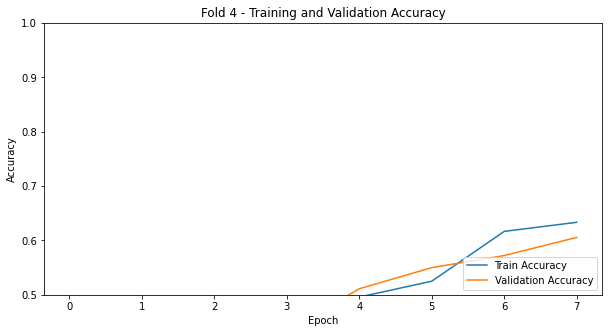

6/6 [==============================] - 2s 303ms/step - loss: 1.1532 - accuracy: 0.5444
Validation Accuracy for fold 4: 54.44%


accuracy,▁▃▄▅▆▆██
epoch,▁▂▃▄▅▆▇█
loss,█▆▅▄▄▃▁▁
val_accuracy,▁▃▃▄▆▇▇█
val_loss,█▆▄▆▄▂▁▂
accuracy,0.63333
best_epoch,6
best_val_loss,1.04334
epoch,7
loss,0.97749
val_accuracy,0.60556


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 5 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/8
23/23 [==============================] - 11s 435ms/step - loss: 1.8330 - accuracy: 0.2444 - val_loss: 1.7928 - val_accuracy: 0.3167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221331-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221331-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 2/8
23/23 [==============================] - 10s 421ms/step - loss: 1.5065 - accuracy: 0.3722 - val_loss: 1.3994 - val_accuracy: 0.3833
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221331-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221331-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 3/8
23/23 [==============================] - 10s 409ms/step - loss: 1.3400 - accuracy: 0.4403 - val_loss: 1.7008 - val_accuracy: 0.3722
Epoch 4/8
23/23 [==============================] - 9s 403ms/step - loss: 1.3518 - accuracy: 0.4639 - val_loss: 1.3405 - val_accuracy: 0.4278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221331-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221331-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 5/8
23/23 [==============================] - 9s 400ms/step - loss: 1.1627 - accuracy: 0.5125 - val_loss: 1.1371 - val_accuracy: 0.5444
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221331-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221331-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 6/8
23/23 [==============================] - 9s 402ms/step - loss: 1.0612 - accuracy: 0.5653 - val_loss: 1.1145 - val_accuracy: 0.5389
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221331-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221331-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 7/8
23/23 [==============================] - 9s 401ms/step - loss: 0.9967 - accuracy: 0.6014 - val_loss: 1.0508 - val_accuracy: 0.6278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221331-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221331-0x0f6cyy/files/model-best)... Done. 0.0s


Epoch 8/8
23/23 [==============================] - 10s 410ms/step - loss: 0.9197 - accuracy: 0.6431 - val_loss: 1.0256 - val_accuracy: 0.5944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221331-0x0f6cyy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221331-0x0f6cyy/files/model-best)... Done. 0.0s


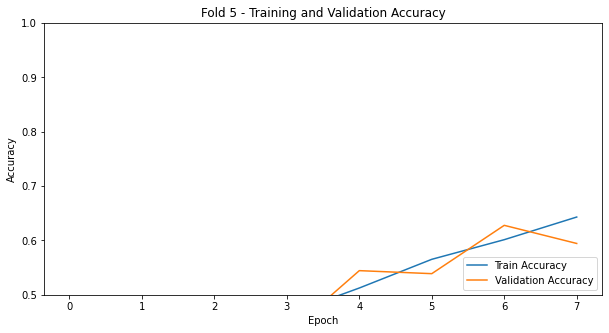

6/6 [==============================] - 2s 299ms/step - loss: 1.0028 - accuracy: 0.5944
Validation Accuracy for fold 5: 59.44%


accuracy,▁▃▄▅▆▇▇█
epoch,▁▂▃▄▅▆▇█
loss,█▅▄▄▃▂▂▁
val_accuracy,▁▃▂▃▆▆█▇
val_loss,█▄▇▄▂▂▁▁
accuracy,0.64306
best_epoch,7
best_val_loss,1.02562
epoch,7
loss,0.91972
val_accuracy,0.59444


wandb: Agent Starting Run: r9d2k93v with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.04093761533320808


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 428ms/step - loss: 1.7653 - accuracy: 0.2833 - val_loss: 1.5915 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221518-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221518-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 9s 403ms/step - loss: 1.4946 - accuracy: 0.3681 - val_loss: 1.4538 - val_accuracy: 0.4056
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221518-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221518-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 10s 405ms/step - loss: 1.3843 - accuracy: 0.4250 - val_loss: 1.3642 - val_accuracy: 0.4444
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221518-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221518-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 9s 402ms/step - loss: 1.3061 - accuracy: 0.4903 - val_loss: 1.2962 - val_accuracy: 0.4944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221518-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221518-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 5/7
23/23 [==============================] - 10s 414ms/step - loss: 1.1932 - accuracy: 0.5375 - val_loss: 1.2269 - val_accuracy: 0.5278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221518-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221518-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 6/7
23/23 [==============================] - 9s 404ms/step - loss: 1.1093 - accuracy: 0.5667 - val_loss: 1.2357 - val_accuracy: 0.5500
Epoch 7/7
23/23 [==============================] - 9s 415ms/step - loss: 1.0261 - accuracy: 0.6097 - val_loss: 1.1970 - val_accuracy: 0.4944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221518-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221518-r9d2k93v/files/model-best)... Done. 0.0s


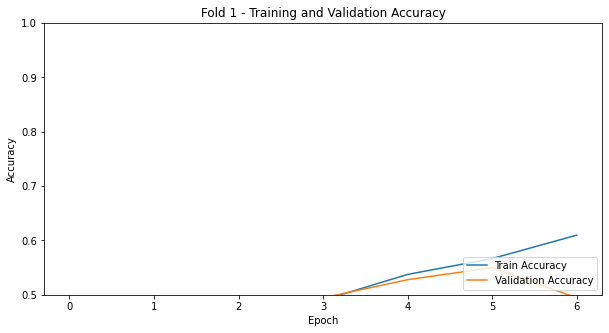

6/6 [==============================] - 2s 288ms/step - loss: 1.1828 - accuracy: 0.5056
Validation Accuracy for fold 1: 50.56%


accuracy,▁▃▄▅▆▇█
epoch,▁▂▃▅▆▇█
loss,█▅▄▄▃▂▁
val_accuracy,▁▃▅▆▇█▆
val_loss,█▆▄▃▂▂▁
accuracy,0.60972
best_epoch,6
best_val_loss,1.19696
epoch,6
loss,1.02606
val_accuracy,0.49444


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 2 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 428ms/step - loss: 1.8048 - accuracy: 0.2444 - val_loss: 1.6926 - val_accuracy: 0.3667
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221650-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221650-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 10s 405ms/step - loss: 1.5250 - accuracy: 0.3722 - val_loss: 1.4996 - val_accuracy: 0.3944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221650-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221650-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 9s 404ms/step - loss: 1.4203 - accuracy: 0.4097 - val_loss: 1.4567 - val_accuracy: 0.3778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221650-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221650-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 10s 407ms/step - loss: 1.3357 - accuracy: 0.4583 - val_loss: 1.3584 - val_accuracy: 0.4278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221650-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221650-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 5/7
23/23 [==============================] - 10s 412ms/step - loss: 1.1969 - accuracy: 0.5250 - val_loss: 1.2842 - val_accuracy: 0.4889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221650-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221650-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 6/7
23/23 [==============================] - 9s 400ms/step - loss: 1.1835 - accuracy: 0.5306 - val_loss: 1.2947 - val_accuracy: 0.4944
Epoch 7/7
23/23 [==============================] - 9s 419ms/step - loss: 1.0764 - accuracy: 0.5764 - val_loss: 1.2438 - val_accuracy: 0.5278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221650-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221650-r9d2k93v/files/model-best)... Done. 0.0s


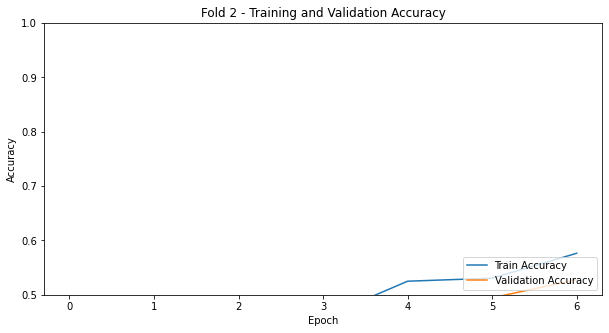

6/6 [==============================] - 2s 290ms/step - loss: 1.2489 - accuracy: 0.5722
Validation Accuracy for fold 2: 57.22%


accuracy,▁▄▄▆▇▇█
epoch,▁▂▃▅▆▇█
loss,█▅▄▃▂▂▁
val_accuracy,▁▂▁▄▆▇█
val_loss,█▅▄▃▂▂▁
accuracy,0.57639
best_epoch,6
best_val_loss,1.24376
epoch,6
loss,1.07644
val_accuracy,0.52778


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 3 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 432ms/step - loss: 1.9159 - accuracy: 0.1889 - val_loss: 1.6941 - val_accuracy: 0.2778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221817-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221817-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 9s 401ms/step - loss: 1.6159 - accuracy: 0.3333 - val_loss: 1.4879 - val_accuracy: 0.3944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221817-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221817-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 9s 405ms/step - loss: 1.5397 - accuracy: 0.3694 - val_loss: 1.4291 - val_accuracy: 0.3833
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221817-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221817-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 10s 425ms/step - loss: 1.3823 - accuracy: 0.4278 - val_loss: 1.3541 - val_accuracy: 0.3944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221817-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221817-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 5/7
23/23 [==============================] - 10s 421ms/step - loss: 1.2647 - accuracy: 0.4611 - val_loss: 1.2101 - val_accuracy: 0.5333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221817-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221817-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 6/7
23/23 [==============================] - 10s 413ms/step - loss: 1.1151 - accuracy: 0.5681 - val_loss: 1.2147 - val_accuracy: 0.5333
Epoch 7/7
23/23 [==============================] - 9s 407ms/step - loss: 1.0901 - accuracy: 0.5528 - val_loss: 1.0595 - val_accuracy: 0.5611
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221817-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221817-r9d2k93v/files/model-best)... Done. 0.0s


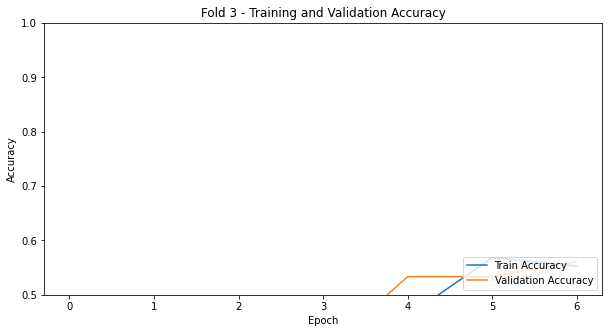

6/6 [==============================] - 2s 291ms/step - loss: 1.1330 - accuracy: 0.5444
Validation Accuracy for fold 3: 54.44%


accuracy,▁▄▄▅▆██
epoch,▁▂▃▅▆▇█
loss,█▅▅▃▂▁▁
val_accuracy,▁▄▄▄▇▇█
val_loss,█▆▅▄▃▃▁
accuracy,0.55278
best_epoch,6
best_val_loss,1.05951
epoch,6
loss,1.0901
val_accuracy,0.56111


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 4 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 426ms/step - loss: 1.9121 - accuracy: 0.2194 - val_loss: 1.6857 - val_accuracy: 0.2722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221944-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221944-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 9s 401ms/step - loss: 1.5306 - accuracy: 0.3458 - val_loss: 1.4500 - val_accuracy: 0.3889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221944-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221944-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 10s 409ms/step - loss: 1.4067 - accuracy: 0.4319 - val_loss: 1.3268 - val_accuracy: 0.4167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221944-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221944-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 9s 403ms/step - loss: 1.3317 - accuracy: 0.4486 - val_loss: 1.3102 - val_accuracy: 0.4444
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221944-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221944-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 5/7
23/23 [==============================] - 10s 410ms/step - loss: 1.2439 - accuracy: 0.4972 - val_loss: 1.3374 - val_accuracy: 0.4611
Epoch 6/7
23/23 [==============================] - 9s 404ms/step - loss: 1.1717 - accuracy: 0.5347 - val_loss: 1.0417 - val_accuracy: 0.6000
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_221944-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_221944-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 7/7
23/23 [==============================] - 10s 414ms/step - loss: 1.0412 - accuracy: 0.6181 - val_loss: 1.3183 - val_accuracy: 0.4722


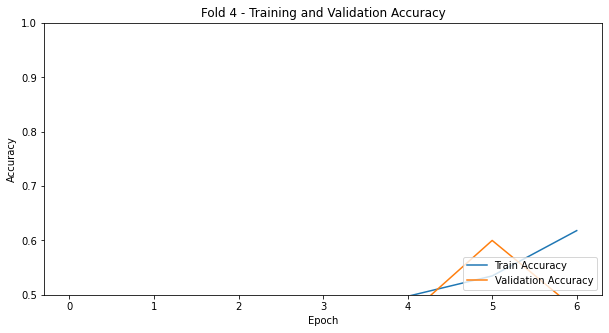

6/6 [==============================] - 2s 283ms/step - loss: 1.2710 - accuracy: 0.4778
Validation Accuracy for fold 4: 47.78%


accuracy,▁▃▅▅▆▇█
epoch,▁▂▃▅▆▇█
loss,█▅▄▃▃▂▁
val_accuracy,▁▃▄▅▅█▅
val_loss,█▅▄▄▄▁▄
accuracy,0.61806
best_epoch,5
best_val_loss,1.04166
epoch,6
loss,1.04122
val_accuracy,0.47222


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 5 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 427ms/step - loss: 1.9442 - accuracy: 0.2292 - val_loss: 1.8665 - val_accuracy: 0.2278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222112-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222112-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 9s 403ms/step - loss: 1.6271 - accuracy: 0.2931 - val_loss: 1.6443 - val_accuracy: 0.3222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222112-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222112-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 9s 403ms/step - loss: 1.5095 - accuracy: 0.3653 - val_loss: 1.5136 - val_accuracy: 0.3833
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222112-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222112-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 10s 417ms/step - loss: 1.3705 - accuracy: 0.4319 - val_loss: 1.3508 - val_accuracy: 0.4778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222112-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222112-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 5/7
23/23 [==============================] - 10s 406ms/step - loss: 1.2780 - accuracy: 0.4986 - val_loss: 1.2139 - val_accuracy: 0.5222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222112-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222112-r9d2k93v/files/model-best)... Done. 0.0s


Epoch 6/7
23/23 [==============================] - 10s 413ms/step - loss: 1.1930 - accuracy: 0.5333 - val_loss: 1.3885 - val_accuracy: 0.4056
Epoch 7/7
23/23 [==============================] - 9s 403ms/step - loss: 1.1741 - accuracy: 0.5167 - val_loss: 1.1636 - val_accuracy: 0.5611
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222112-r9d2k93v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222112-r9d2k93v/files/model-best)... Done. 0.0s


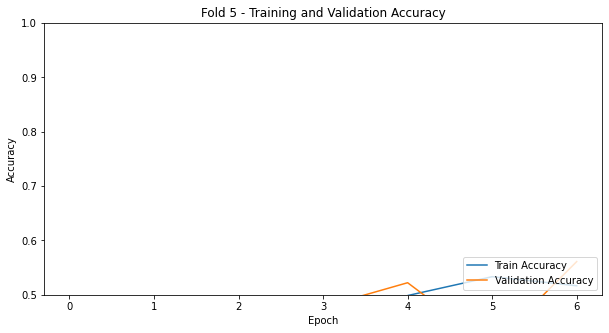

6/6 [==============================] - 2s 284ms/step - loss: 1.1884 - accuracy: 0.5611
Validation Accuracy for fold 5: 56.11%


accuracy,▁▂▄▆▇██
epoch,▁▂▃▅▆▇█
loss,█▅▄▃▂▁▁
val_accuracy,▁▃▄▆▇▅█
val_loss,█▆▄▃▂▃▁
accuracy,0.51667
best_epoch,6
best_val_loss,1.16363
epoch,6
loss,1.17406
val_accuracy,0.56111


wandb: Agent Starting Run: yh0r9lct with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.06134043661399705


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/8
23/23 [==============================] - 11s 426ms/step - loss: 1.9478 - accuracy: 0.2292 - val_loss: 1.7538 - val_accuracy: 0.3222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222245-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222245-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 2/8
23/23 [==============================] - 9s 405ms/step - loss: 1.5471 - accuracy: 0.3569 - val_loss: 1.5628 - val_accuracy: 0.3556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222245-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222245-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 3/8
23/23 [==============================] - 10s 409ms/step - loss: 1.3670 - accuracy: 0.4458 - val_loss: 1.3949 - val_accuracy: 0.4000
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222245-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222245-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 4/8
23/23 [==============================] - 9s 401ms/step - loss: 1.2828 - accuracy: 0.4958 - val_loss: 1.3413 - val_accuracy: 0.4444
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222245-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222245-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 5/8
23/23 [==============================] - 10s 407ms/step - loss: 1.1609 - accuracy: 0.5431 - val_loss: 1.2276 - val_accuracy: 0.5444
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222245-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222245-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 6/8
23/23 [==============================] - 10s 414ms/step - loss: 1.0434 - accuracy: 0.5750 - val_loss: 1.1645 - val_accuracy: 0.5222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222245-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222245-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 7/8
23/23 [==============================] - 10s 408ms/step - loss: 0.9970 - accuracy: 0.6444 - val_loss: 1.2598 - val_accuracy: 0.4667
Epoch 8/8
23/23 [==============================] - 9s 404ms/step - loss: 0.9229 - accuracy: 0.6472 - val_loss: 1.1003 - val_accuracy: 0.5556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222245-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222245-yh0r9lct/files/model-best)... Done. 0.0s


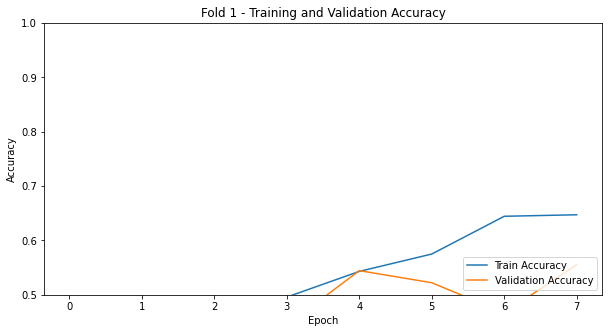

6/6 [==============================] - 2s 291ms/step - loss: 1.1587 - accuracy: 0.5611
Validation Accuracy for fold 1: 56.11%


accuracy,▁▃▅▅▆▇██
epoch,▁▂▃▄▅▆▇█
loss,█▅▄▃▃▂▂▁
val_accuracy,▁▂▃▅█▇▅█
val_loss,█▆▄▄▂▂▃▁
accuracy,0.64722
best_epoch,7
best_val_loss,1.10028
epoch,7
loss,0.92293
val_accuracy,0.55556


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 2 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/8
23/23 [==============================] - 11s 425ms/step - loss: 1.8226 - accuracy: 0.2528 - val_loss: 1.5791 - val_accuracy: 0.3667
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222429-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222429-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 2/8
23/23 [==============================] - 9s 402ms/step - loss: 1.5646 - accuracy: 0.3444 - val_loss: 1.5658 - val_accuracy: 0.3833
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222429-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222429-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 3/8
23/23 [==============================] - 9s 405ms/step - loss: 1.3932 - accuracy: 0.4014 - val_loss: 1.3959 - val_accuracy: 0.4778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222429-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222429-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 4/8
23/23 [==============================] - 9s 404ms/step - loss: 1.3130 - accuracy: 0.4514 - val_loss: 1.3817 - val_accuracy: 0.4778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222429-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222429-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 5/8
23/23 [==============================] - 10s 405ms/step - loss: 1.2352 - accuracy: 0.5014 - val_loss: 1.4100 - val_accuracy: 0.4722
Epoch 6/8
23/23 [==============================] - 9s 403ms/step - loss: 1.1482 - accuracy: 0.5500 - val_loss: 1.3822 - val_accuracy: 0.4944
Epoch 7/8
23/23 [==============================] - 9s 404ms/step - loss: 1.1284 - accuracy: 0.5403 - val_loss: 1.3114 - val_accuracy: 0.5167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222429-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222429-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 8/8
23/23 [==============================] - 10s 408ms/step - loss: 0.9993 - accuracy: 0.6042 - val_loss: 1.2381 - val_accuracy: 0.5389
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222429-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222429-yh0r9lct/files/model-best)... Done. 0.0s


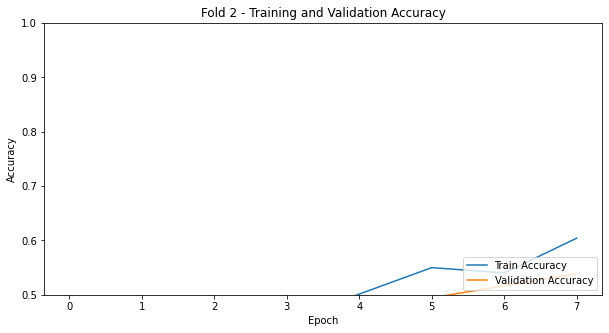

6/6 [==============================] - 2s 286ms/step - loss: 1.2313 - accuracy: 0.5556
Validation Accuracy for fold 2: 55.56%


accuracy,▁▃▄▅▆▇▇█
epoch,▁▂▃▄▅▆▇█
loss,█▆▄▄▃▂▂▁
val_accuracy,▁▂▆▆▅▆▇█
val_loss,██▄▄▅▄▃▁
accuracy,0.60417
best_epoch,7
best_val_loss,1.2381
epoch,7
loss,0.99925
val_accuracy,0.53889


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 3 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/8
23/23 [==============================] - 11s 424ms/step - loss: 1.9549 - accuracy: 0.2625 - val_loss: 1.5668 - val_accuracy: 0.3667
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222606-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222606-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 2/8
23/23 [==============================] - 9s 397ms/step - loss: 1.5294 - accuracy: 0.3750 - val_loss: 1.4045 - val_accuracy: 0.4333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222606-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222606-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 3/8
23/23 [==============================] - 9s 403ms/step - loss: 1.3546 - accuracy: 0.4556 - val_loss: 1.2627 - val_accuracy: 0.5000
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222606-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222606-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 4/8
23/23 [==============================] - 10s 408ms/step - loss: 1.2819 - accuracy: 0.4597 - val_loss: 1.3756 - val_accuracy: 0.4833
Epoch 5/8
23/23 [==============================] - 9s 406ms/step - loss: 1.1779 - accuracy: 0.5333 - val_loss: 1.2386 - val_accuracy: 0.4889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222606-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222606-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 6/8
23/23 [==============================] - 10s 409ms/step - loss: 1.0556 - accuracy: 0.5694 - val_loss: 1.0904 - val_accuracy: 0.5944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222606-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222606-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 7/8
23/23 [==============================] - 9s 400ms/step - loss: 1.0355 - accuracy: 0.5917 - val_loss: 1.1829 - val_accuracy: 0.5222
Epoch 8/8
23/23 [==============================] - 10s 410ms/step - loss: 0.9649 - accuracy: 0.5972 - val_loss: 0.9438 - val_accuracy: 0.6222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222606-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222606-yh0r9lct/files/model-best)... Done. 0.0s


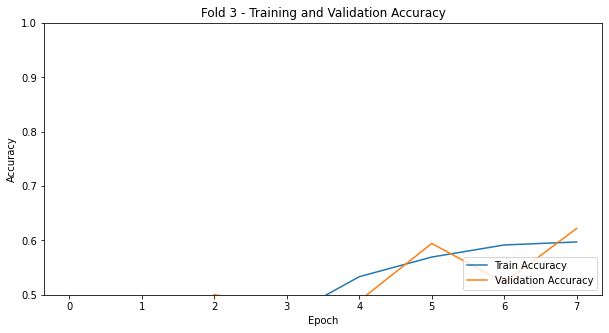

6/6 [==============================] - 2s 284ms/step - loss: 0.9630 - accuracy: 0.6056
Validation Accuracy for fold 3: 60.56%


accuracy,▁▃▅▅▇▇██
epoch,▁▂▃▄▅▆▇█
loss,█▅▄▃▃▂▁▁
val_accuracy,▁▃▅▄▄▇▅█
val_loss,█▆▅▆▄▃▄▁
accuracy,0.59722
best_epoch,7
best_val_loss,0.94382
epoch,7
loss,0.96491
val_accuracy,0.62222


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 4 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/8
23/23 [==============================] - 11s 420ms/step - loss: 1.8487 - accuracy: 0.2500 - val_loss: 1.6560 - val_accuracy: 0.2722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222743-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222743-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 2/8
23/23 [==============================] - 10s 419ms/step - loss: 1.5999 - accuracy: 0.3625 - val_loss: 1.5559 - val_accuracy: 0.3556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222743-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222743-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 3/8
23/23 [==============================] - 10s 414ms/step - loss: 1.4893 - accuracy: 0.3708 - val_loss: 1.3683 - val_accuracy: 0.4333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222743-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222743-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 4/8
23/23 [==============================] - 9s 404ms/step - loss: 1.3361 - accuracy: 0.4500 - val_loss: 1.2542 - val_accuracy: 0.5056
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222743-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222743-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 5/8
23/23 [==============================] - 9s 417ms/step - loss: 1.2220 - accuracy: 0.5306 - val_loss: 1.2560 - val_accuracy: 0.5056
Epoch 6/8
23/23 [==============================] - 9s 408ms/step - loss: 1.2424 - accuracy: 0.5139 - val_loss: 1.2634 - val_accuracy: 0.4833
Epoch 7/8
23/23 [==============================] - 10s 412ms/step - loss: 1.1496 - accuracy: 0.5708 - val_loss: 1.3040 - val_accuracy: 0.4556
Epoch 8/8
23/23 [==============================] - 9s 402ms/step - loss: 1.0697 - accuracy: 0.5819 - val_loss: 1.2633 - val_accuracy: 0.5111


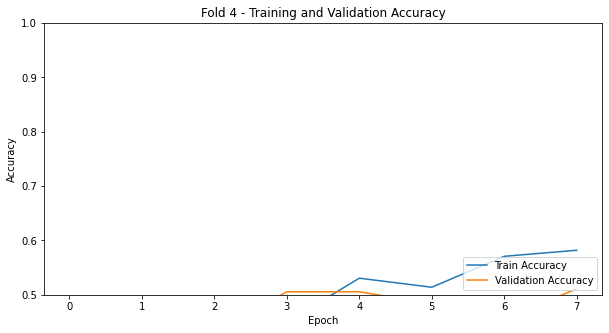

6/6 [==============================] - 2s 301ms/step - loss: 1.2230 - accuracy: 0.5167
Validation Accuracy for fold 4: 51.67%


accuracy,▁▃▄▅▇▇██
epoch,▁▂▃▄▅▆▇█
loss,█▆▅▃▂▃▂▁
val_accuracy,▁▃▆██▇▆█
val_loss,█▆▃▁▁▁▂▁
accuracy,0.58194
best_epoch,3
best_val_loss,1.25422
epoch,7
loss,1.06969
val_accuracy,0.51111


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 5 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/8
23/23 [==============================] - 11s 433ms/step - loss: 1.8281 - accuracy: 0.2722 - val_loss: 1.6416 - val_accuracy: 0.3389
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222916-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222916-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 2/8
23/23 [==============================] - 9s 404ms/step - loss: 1.5158 - accuracy: 0.3528 - val_loss: 1.5053 - val_accuracy: 0.4056
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222916-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222916-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 3/8
23/23 [==============================] - 9s 401ms/step - loss: 1.4356 - accuracy: 0.4250 - val_loss: 1.4349 - val_accuracy: 0.4389
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222916-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222916-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 4/8
23/23 [==============================] - 9s 404ms/step - loss: 1.3201 - accuracy: 0.4694 - val_loss: 1.3646 - val_accuracy: 0.4500
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222916-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222916-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 5/8
23/23 [==============================] - 9s 405ms/step - loss: 1.2139 - accuracy: 0.5278 - val_loss: 1.2389 - val_accuracy: 0.4611
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222916-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222916-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 6/8
23/23 [==============================] - 10s 404ms/step - loss: 1.1698 - accuracy: 0.5389 - val_loss: 1.1791 - val_accuracy: 0.5056
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222916-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222916-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 7/8
23/23 [==============================] - 9s 405ms/step - loss: 1.0534 - accuracy: 0.5847 - val_loss: 1.1287 - val_accuracy: 0.5222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222916-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222916-yh0r9lct/files/model-best)... Done. 0.0s


Epoch 8/8
23/23 [==============================] - 10s 425ms/step - loss: 0.9535 - accuracy: 0.6250 - val_loss: 0.9932 - val_accuracy: 0.5889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_222916-yh0r9lct/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_222916-yh0r9lct/files/model-best)... Done. 0.0s


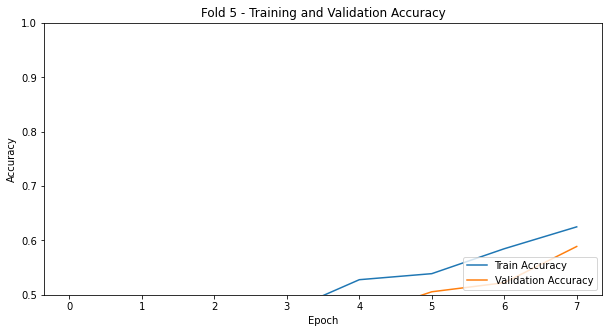

6/6 [==============================] - ETA: 0s - loss: 1.0276 - accuracy: 0.58 - 2s 289ms/step - loss: 1.0276 - accuracy: 0.5889
Validation Accuracy for fold 5: 58.89%


accuracy,▁▃▄▅▆▆▇█
epoch,▁▂▃▄▅▆▇█
loss,█▆▅▄▃▃▂▁
val_accuracy,▁▃▄▄▄▆▆█
val_loss,█▇▆▅▄▃▂▁
accuracy,0.625
best_epoch,7
best_val_loss,0.9932
epoch,7
loss,0.95349
val_accuracy,0.58889


wandb: Agent Starting Run: 10elsrio with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.047230444112630256


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/8
23/23 [==============================] - 11s 431ms/step - loss: 1.8535 - accuracy: 0.2375 - val_loss: 1.7152 - val_accuracy: 0.2333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223103-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223103-10elsrio/files/model-best)... Done. 0.0s


Epoch 2/8
23/23 [==============================] - 10s 408ms/step - loss: 1.5610 - accuracy: 0.3306 - val_loss: 1.5513 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223103-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223103-10elsrio/files/model-best)... Done. 0.0s


Epoch 3/8
23/23 [==============================] - 9s 403ms/step - loss: 1.4822 - accuracy: 0.3806 - val_loss: 1.4645 - val_accuracy: 0.3889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223103-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223103-10elsrio/files/model-best)... Done. 0.0s


Epoch 4/8
23/23 [==============================] - 9s 401ms/step - loss: 1.3712 - accuracy: 0.4389 - val_loss: 1.4568 - val_accuracy: 0.3278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223103-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223103-10elsrio/files/model-best)... Done. 0.0s


Epoch 5/8
23/23 [==============================] - 10s 416ms/step - loss: 1.2705 - accuracy: 0.4806 - val_loss: 1.3332 - val_accuracy: 0.4056
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223103-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223103-10elsrio/files/model-best)... Done. 0.0s


Epoch 6/8
23/23 [==============================] - 9s 394ms/step - loss: 1.1403 - accuracy: 0.5472 - val_loss: 1.2337 - val_accuracy: 0.5167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223103-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223103-10elsrio/files/model-best)... Done. 0.0s


Epoch 7/8
23/23 [==============================] - 10s 407ms/step - loss: 1.0233 - accuracy: 0.6069 - val_loss: 1.2377 - val_accuracy: 0.4778
Epoch 8/8
23/23 [==============================] - 9s 397ms/step - loss: 0.8748 - accuracy: 0.6847 - val_loss: 1.2205 - val_accuracy: 0.5056
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223103-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223103-10elsrio/files/model-best)... Done. 0.0s


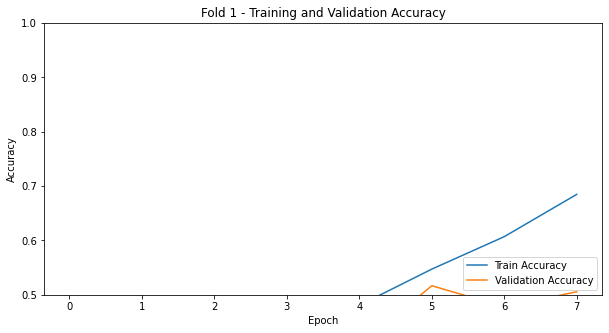

6/6 [==============================] - 2s 304ms/step - loss: 1.2405 - accuracy: 0.5333
Validation Accuracy for fold 1: 53.33%


accuracy,▁▂▃▄▅▆▇█
epoch,▁▂▃▄▅▆▇█
loss,█▆▅▅▄▃▂▁
val_accuracy,▁▃▅▃▅█▇█
val_loss,█▆▄▄▃▁▁▁
accuracy,0.68472
best_epoch,7
best_val_loss,1.22052
epoch,7
loss,0.87478
val_accuracy,0.50556


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 2 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/8
23/23 [==============================] - 11s 426ms/step - loss: 1.7729 - accuracy: 0.2597 - val_loss: 1.6422 - val_accuracy: 0.3000
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223246-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223246-10elsrio/files/model-best)... Done. 0.0s


Epoch 2/8
23/23 [==============================] - 9s 399ms/step - loss: 1.4881 - accuracy: 0.3625 - val_loss: 1.5406 - val_accuracy: 0.4000
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223246-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223246-10elsrio/files/model-best)... Done. 0.0s


Epoch 3/8
23/23 [==============================] - 9s 405ms/step - loss: 1.3249 - accuracy: 0.4556 - val_loss: 1.3676 - val_accuracy: 0.4111
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223246-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223246-10elsrio/files/model-best)... Done. 0.0s


Epoch 4/8
23/23 [==============================] - 9s 397ms/step - loss: 1.1966 - accuracy: 0.5222 - val_loss: 1.3243 - val_accuracy: 0.4778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223246-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223246-10elsrio/files/model-best)... Done. 0.0s


Epoch 5/8
23/23 [==============================] - 10s 408ms/step - loss: 1.1699 - accuracy: 0.5111 - val_loss: 1.2662 - val_accuracy: 0.5056
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223246-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223246-10elsrio/files/model-best)... Done. 0.0s


Epoch 6/8
23/23 [==============================] - 9s 400ms/step - loss: 1.1336 - accuracy: 0.5403 - val_loss: 1.3185 - val_accuracy: 0.4833
Epoch 7/8
23/23 [==============================] - 10s 412ms/step - loss: 1.0781 - accuracy: 0.5722 - val_loss: 1.1787 - val_accuracy: 0.5278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223246-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223246-10elsrio/files/model-best)... Done. 0.0s


Epoch 8/8
23/23 [==============================] - 9s 402ms/step - loss: 0.9106 - accuracy: 0.6278 - val_loss: 1.2009 - val_accuracy: 0.6000


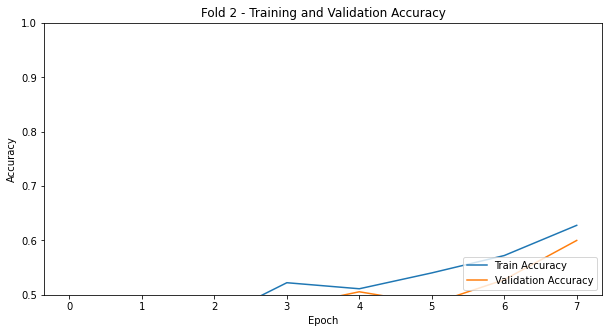

6/6 [==============================] - 2s 289ms/step - loss: 1.2062 - accuracy: 0.5556
Validation Accuracy for fold 2: 55.56%


accuracy,▁▃▅▆▆▆▇█
epoch,▁▂▃▄▅▆▇█
loss,█▆▄▃▃▃▂▁
val_accuracy,▁▃▄▅▆▅▆█
val_loss,█▆▄▃▂▃▁▁
accuracy,0.62778
best_epoch,6
best_val_loss,1.17869
epoch,7
loss,0.91057
val_accuracy,0.6


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 3 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/8
23/23 [==============================] - 11s 422ms/step - loss: 2.0371 - accuracy: 0.2139 - val_loss: 1.7491 - val_accuracy: 0.2222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223424-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223424-10elsrio/files/model-best)... Done. 0.0s


Epoch 2/8
23/23 [==============================] - 9s 402ms/step - loss: 1.6892 - accuracy: 0.2653 - val_loss: 1.5543 - val_accuracy: 0.3389
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223424-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223424-10elsrio/files/model-best)... Done. 0.0s


Epoch 3/8
23/23 [==============================] - 10s 409ms/step - loss: 1.5039 - accuracy: 0.3708 - val_loss: 1.5093 - val_accuracy: 0.3833
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223424-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223424-10elsrio/files/model-best)... Done. 0.0s


Epoch 4/8
23/23 [==============================] - 9s 398ms/step - loss: 1.4066 - accuracy: 0.4167 - val_loss: 1.3605 - val_accuracy: 0.4278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223424-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223424-10elsrio/files/model-best)... Done. 0.0s


Epoch 5/8
23/23 [==============================] - 9s 405ms/step - loss: 1.3105 - accuracy: 0.4764 - val_loss: 1.2113 - val_accuracy: 0.5278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223424-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223424-10elsrio/files/model-best)... Done. 0.0s


Epoch 6/8
23/23 [==============================] - 9s 397ms/step - loss: 1.1730 - accuracy: 0.5333 - val_loss: 1.1324 - val_accuracy: 0.6056
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223424-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223424-10elsrio/files/model-best)... Done. 0.0s


Epoch 7/8
23/23 [==============================] - 10s 422ms/step - loss: 1.1246 - accuracy: 0.5722 - val_loss: 1.1089 - val_accuracy: 0.5833
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223424-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223424-10elsrio/files/model-best)... Done. 0.0s


Epoch 8/8
23/23 [==============================] - 9s 399ms/step - loss: 1.0868 - accuracy: 0.5611 - val_loss: 1.2143 - val_accuracy: 0.5222


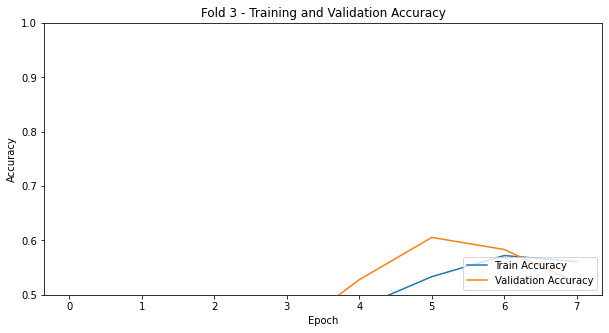

6/6 [==============================] - 2s 301ms/step - loss: 1.2139 - accuracy: 0.5167
Validation Accuracy for fold 3: 51.67%


accuracy,▁▂▄▅▆▇██
epoch,▁▂▃▄▅▆▇█
loss,█▅▄▃▃▂▁▁
val_accuracy,▁▃▄▅▇██▆
val_loss,█▆▅▄▂▁▁▂
accuracy,0.56111
best_epoch,6
best_val_loss,1.10891
epoch,7
loss,1.08679
val_accuracy,0.52222


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 4 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/8
23/23 [==============================] - 11s 458ms/step - loss: 1.8713 - accuracy: 0.2514 - val_loss: 1.6275 - val_accuracy: 0.3389
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223603-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223603-10elsrio/files/model-best)... Done. 0.0s


Epoch 2/8
23/23 [==============================] - 10s 420ms/step - loss: 1.5459 - accuracy: 0.3556 - val_loss: 1.4515 - val_accuracy: 0.3444
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223603-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223603-10elsrio/files/model-best)... Done. 0.0s


Epoch 3/8
23/23 [==============================] - 10s 409ms/step - loss: 1.4082 - accuracy: 0.4139 - val_loss: 1.2985 - val_accuracy: 0.4389
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223603-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223603-10elsrio/files/model-best)... Done. 0.0s


Epoch 4/8
23/23 [==============================] - 9s 413ms/step - loss: 1.3280 - accuracy: 0.4569 - val_loss: 1.3171 - val_accuracy: 0.5056
Epoch 5/8
23/23 [==============================] - 10s 415ms/step - loss: 1.2614 - accuracy: 0.5139 - val_loss: 1.1914 - val_accuracy: 0.5167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223603-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223603-10elsrio/files/model-best)... Done. 0.0s


Epoch 6/8
23/23 [==============================] - 10s 408ms/step - loss: 1.1744 - accuracy: 0.5250 - val_loss: 1.1628 - val_accuracy: 0.4833
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223603-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223603-10elsrio/files/model-best)... Done. 0.0s


Epoch 7/8
23/23 [==============================] - 10s 414ms/step - loss: 1.0891 - accuracy: 0.5764 - val_loss: 1.0762 - val_accuracy: 0.5722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223603-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223603-10elsrio/files/model-best)... Done. 0.0s


Epoch 8/8
23/23 [==============================] - 9s 402ms/step - loss: 1.0057 - accuracy: 0.6111 - val_loss: 0.9972 - val_accuracy: 0.6056
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223603-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223603-10elsrio/files/model-best)... Done. 0.0s


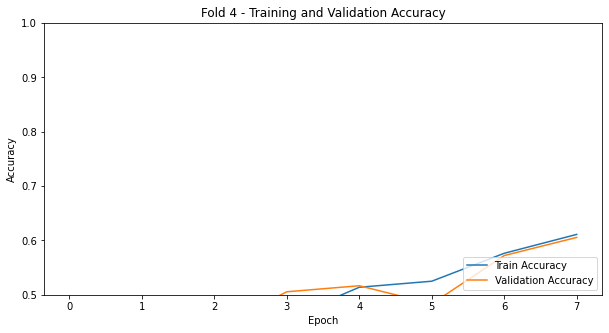

6/6 [==============================] - 2s 295ms/step - loss: 0.9388 - accuracy: 0.6278
Validation Accuracy for fold 4: 62.78%


accuracy,▁▃▄▅▆▆▇█
epoch,▁▂▃▄▅▆▇█
loss,█▅▄▄▃▂▂▁
val_accuracy,▁▁▄▅▆▅▇█
val_loss,█▆▄▅▃▃▂▁
accuracy,0.61111
best_epoch,7
best_val_loss,0.99718
epoch,7
loss,1.00572
val_accuracy,0.60556


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 5 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/8
23/23 [==============================] - 11s 433ms/step - loss: 1.8548 - accuracy: 0.2611 - val_loss: 1.6406 - val_accuracy: 0.3056
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223743-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223743-10elsrio/files/model-best)... Done. 0.0s


Epoch 2/8
23/23 [==============================] - 10s 410ms/step - loss: 1.5197 - accuracy: 0.3639 - val_loss: 1.5245 - val_accuracy: 0.3222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223743-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223743-10elsrio/files/model-best)... Done. 0.0s


Epoch 3/8
23/23 [==============================] - 10s 413ms/step - loss: 1.3614 - accuracy: 0.4431 - val_loss: 1.3175 - val_accuracy: 0.4389
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223743-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223743-10elsrio/files/model-best)... Done. 0.0s


Epoch 4/8
23/23 [==============================] - 9s 403ms/step - loss: 1.2224 - accuracy: 0.4847 - val_loss: 1.3064 - val_accuracy: 0.4778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223743-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223743-10elsrio/files/model-best)... Done. 0.0s


Epoch 5/8
23/23 [==============================] - 10s 414ms/step - loss: 1.1345 - accuracy: 0.5583 - val_loss: 1.2877 - val_accuracy: 0.4833
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223743-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223743-10elsrio/files/model-best)... Done. 0.0s


Epoch 6/8
23/23 [==============================] - 10s 409ms/step - loss: 1.0735 - accuracy: 0.5889 - val_loss: 1.1777 - val_accuracy: 0.5778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223743-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223743-10elsrio/files/model-best)... Done. 0.0s


Epoch 7/8
23/23 [==============================] - 10s 421ms/step - loss: 0.9402 - accuracy: 0.6194 - val_loss: 1.0694 - val_accuracy: 0.5889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223743-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223743-10elsrio/files/model-best)... Done. 0.0s


Epoch 8/8
23/23 [==============================] - 10s 409ms/step - loss: 0.8724 - accuracy: 0.6736 - val_loss: 1.0100 - val_accuracy: 0.6056
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223743-10elsrio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223743-10elsrio/files/model-best)... Done. 0.0s


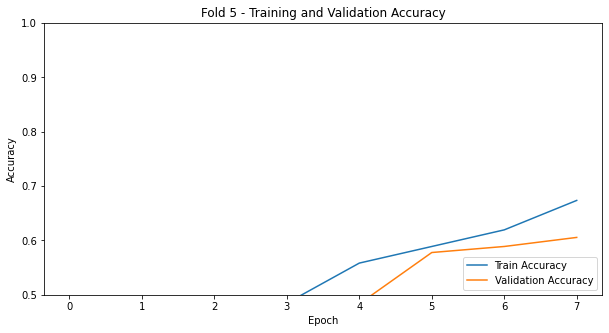

6/6 [==============================] - 2s 290ms/step - loss: 1.0069 - accuracy: 0.6389
Validation Accuracy for fold 5: 63.89%


accuracy,▁▃▄▅▆▇▇█
epoch,▁▂▃▄▅▆▇█
loss,█▆▄▃▃▂▁▁
val_accuracy,▁▁▄▅▅▇██
val_loss,█▇▄▄▄▃▂▁
accuracy,0.67361
best_epoch,7
best_val_loss,1.01001
epoch,7
loss,0.87237
val_accuracy,0.60556


wandb: Agent Starting Run: 2gi9hh83 with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.02815630277434983


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 435ms/step - loss: 1.9760 - accuracy: 0.2194 - val_loss: 1.7578 - val_accuracy: 0.2111
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223930-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223930-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 10s 410ms/step - loss: 1.6681 - accuracy: 0.2931 - val_loss: 1.7734 - val_accuracy: 0.2556
Epoch 3/7
23/23 [==============================] - 9s 405ms/step - loss: 1.5609 - accuracy: 0.3417 - val_loss: 1.5204 - val_accuracy: 0.4000
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223930-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223930-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 9s 402ms/step - loss: 1.3741 - accuracy: 0.4292 - val_loss: 1.4755 - val_accuracy: 0.4278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223930-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223930-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 5/7
23/23 [==============================] - 9s 399ms/step - loss: 1.3169 - accuracy: 0.4792 - val_loss: 1.2805 - val_accuracy: 0.4444
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223930-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223930-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 6/7
23/23 [==============================] - 9s 400ms/step - loss: 1.1601 - accuracy: 0.5458 - val_loss: 1.4272 - val_accuracy: 0.4056
Epoch 7/7
23/23 [==============================] - 10s 412ms/step - loss: 1.0787 - accuracy: 0.5833 - val_loss: 1.1584 - val_accuracy: 0.5167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_223930-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_223930-2gi9hh83/files/model-best)... Done. 0.0s


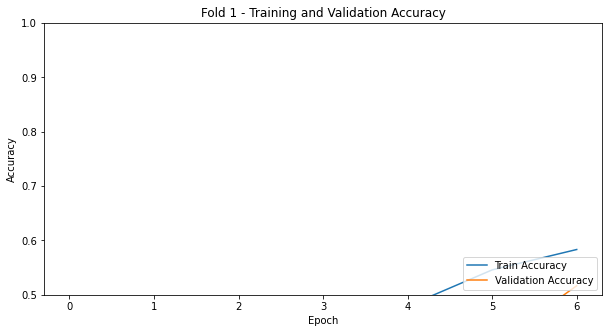

6/6 [==============================] - 2s 298ms/step - loss: 1.1861 - accuracy: 0.4944
Validation Accuracy for fold 1: 49.44%


accuracy,▁▂▃▅▆▇█
epoch,▁▂▃▅▆▇█
loss,█▆▅▃▃▂▁
val_accuracy,▁▂▅▆▆▅█
val_loss,██▅▅▂▄▁
accuracy,0.58333
best_epoch,6
best_val_loss,1.15836
epoch,6
loss,1.07873
val_accuracy,0.51667


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 2 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 430ms/step - loss: 1.8507 - accuracy: 0.2389 - val_loss: 1.7723 - val_accuracy: 0.2167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224100-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224100-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 10s 408ms/step - loss: 1.6251 - accuracy: 0.2972 - val_loss: 1.5762 - val_accuracy: 0.3167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224100-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224100-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 10s 405ms/step - loss: 1.4031 - accuracy: 0.4167 - val_loss: 1.4707 - val_accuracy: 0.3722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224100-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224100-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 9s 403ms/step - loss: 1.3777 - accuracy: 0.4292 - val_loss: 1.4782 - val_accuracy: 0.4056
Epoch 5/7
23/23 [==============================] - 10s 412ms/step - loss: 1.2665 - accuracy: 0.4778 - val_loss: 1.3920 - val_accuracy: 0.4278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224100-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224100-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 6/7
23/23 [==============================] - 10s 414ms/step - loss: 1.2115 - accuracy: 0.5125 - val_loss: 1.4203 - val_accuracy: 0.4056
Epoch 7/7
23/23 [==============================] - 10s 422ms/step - loss: 1.2106 - accuracy: 0.5208 - val_loss: 1.3095 - val_accuracy: 0.5111
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224100-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224100-2gi9hh83/files/model-best)... Done. 0.0s


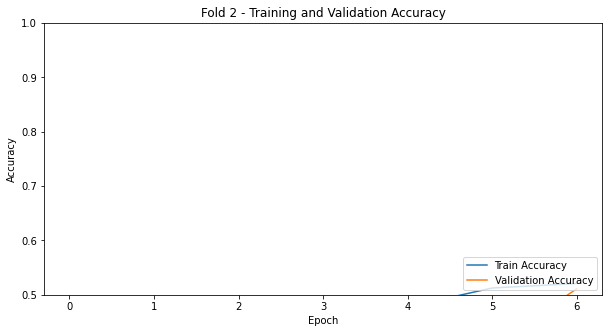

6/6 [==============================] - 2s 288ms/step - loss: 1.3325 - accuracy: 0.5222
Validation Accuracy for fold 2: 52.22%


accuracy,▁▂▅▆▇██
epoch,▁▂▃▅▆▇█
loss,█▆▃▃▂▁▁
val_accuracy,▁▃▅▅▆▅█
val_loss,█▅▃▄▂▃▁
accuracy,0.52083
best_epoch,6
best_val_loss,1.30952
epoch,6
loss,1.21055
val_accuracy,0.51111


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 3 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 438ms/step - loss: 1.9294 - accuracy: 0.2333 - val_loss: 1.7182 - val_accuracy: 0.2833
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224227-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224227-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 10s 409ms/step - loss: 1.6888 - accuracy: 0.2806 - val_loss: 1.5525 - val_accuracy: 0.3611
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224227-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224227-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 10s 417ms/step - loss: 1.5457 - accuracy: 0.3389 - val_loss: 1.3868 - val_accuracy: 0.4167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224227-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224227-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 10s 408ms/step - loss: 1.4248 - accuracy: 0.3861 - val_loss: 1.4305 - val_accuracy: 0.4111
Epoch 5/7
23/23 [==============================] - 9s 406ms/step - loss: 1.3952 - accuracy: 0.4181 - val_loss: 1.2721 - val_accuracy: 0.4722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224227-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224227-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 6/7
23/23 [==============================] - 10s 408ms/step - loss: 1.2953 - accuracy: 0.4917 - val_loss: 1.3139 - val_accuracy: 0.4167
Epoch 7/7
23/23 [==============================] - 9s 418ms/step - loss: 1.1826 - accuracy: 0.5431 - val_loss: 1.1786 - val_accuracy: 0.5167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224227-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224227-2gi9hh83/files/model-best)... Done. 0.0s


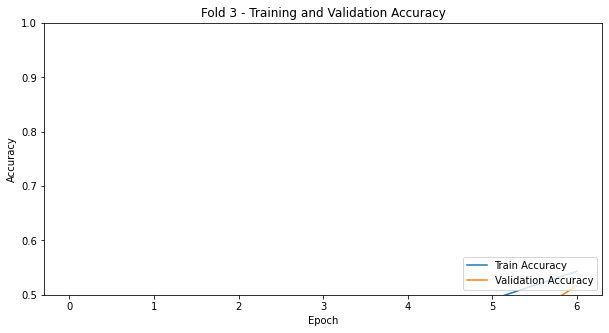

6/6 [==============================] - 2s 284ms/step - loss: 1.1804 - accuracy: 0.5222
Validation Accuracy for fold 3: 52.22%


accuracy,▁▂▃▄▅▇█
epoch,▁▂▃▅▆▇█
loss,█▆▄▃▃▂▁
val_accuracy,▁▃▅▅▇▅█
val_loss,█▆▄▄▂▃▁
accuracy,0.54306
best_epoch,6
best_val_loss,1.17856
epoch,6
loss,1.18264
val_accuracy,0.51667


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 4 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 437ms/step - loss: 1.8618 - accuracy: 0.2486 - val_loss: 1.6587 - val_accuracy: 0.2444
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224355-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224355-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 9s 402ms/step - loss: 1.5686 - accuracy: 0.3444 - val_loss: 1.5241 - val_accuracy: 0.3500
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224355-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224355-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 10s 407ms/step - loss: 1.4695 - accuracy: 0.4042 - val_loss: 1.5064 - val_accuracy: 0.3611
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224355-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224355-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 9s 405ms/step - loss: 1.4160 - accuracy: 0.4250 - val_loss: 1.3902 - val_accuracy: 0.3889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224355-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224355-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 5/7
23/23 [==============================] - 9s 403ms/step - loss: 1.3641 - accuracy: 0.4486 - val_loss: 1.3553 - val_accuracy: 0.4222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224355-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224355-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 6/7
23/23 [==============================] - 10s 414ms/step - loss: 1.2270 - accuracy: 0.5306 - val_loss: 1.2006 - val_accuracy: 0.5278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224355-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224355-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 7/7
23/23 [==============================] - 9s 404ms/step - loss: 1.2229 - accuracy: 0.5056 - val_loss: 1.2197 - val_accuracy: 0.4778


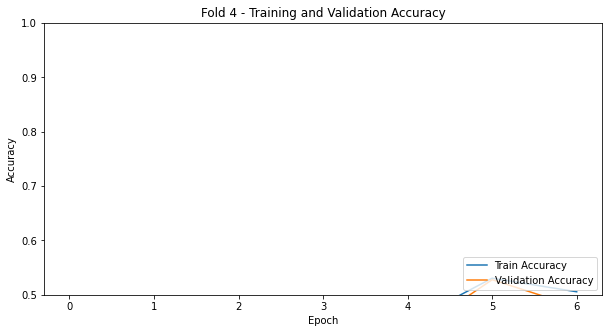

6/6 [==============================] - 2s 287ms/step - loss: 1.2088 - accuracy: 0.4778
Validation Accuracy for fold 4: 47.78%


accuracy,▁▃▅▅▆█▇
epoch,▁▂▃▅▆▇█
loss,█▅▄▃▃▁▁
val_accuracy,▁▄▄▅▅█▇
val_loss,█▆▆▄▃▁▁
accuracy,0.50556
best_epoch,5
best_val_loss,1.20058
epoch,6
loss,1.22285
val_accuracy,0.47778


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 5 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 429ms/step - loss: 1.9649 - accuracy: 0.2264 - val_loss: 1.7821 - val_accuracy: 0.2667
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224523-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224523-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 9s 402ms/step - loss: 1.5964 - accuracy: 0.3236 - val_loss: 1.5019 - val_accuracy: 0.3778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224523-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224523-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 10s 409ms/step - loss: 1.4359 - accuracy: 0.3986 - val_loss: 1.3489 - val_accuracy: 0.4333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224523-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224523-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 9s 401ms/step - loss: 1.3256 - accuracy: 0.4681 - val_loss: 1.3536 - val_accuracy: 0.4778
Epoch 5/7
23/23 [==============================] - 9s 406ms/step - loss: 1.2410 - accuracy: 0.5097 - val_loss: 1.2816 - val_accuracy: 0.4833
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224523-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224523-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 6/7
23/23 [==============================] - 10s 409ms/step - loss: 1.1842 - accuracy: 0.5361 - val_loss: 1.2185 - val_accuracy: 0.5222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224523-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224523-2gi9hh83/files/model-best)... Done. 0.0s


Epoch 7/7
23/23 [==============================] - 9s 404ms/step - loss: 1.0676 - accuracy: 0.5986 - val_loss: 1.2003 - val_accuracy: 0.5056
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224523-2gi9hh83/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224523-2gi9hh83/files/model-best)... Done. 0.0s


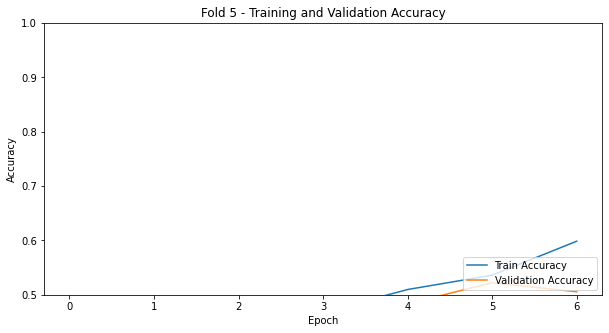

6/6 [==============================] - 2s 282ms/step - loss: 1.2000 - accuracy: 0.4889
Validation Accuracy for fold 5: 48.89%


accuracy,▁▃▄▆▆▇█
epoch,▁▂▃▅▆▇█
loss,█▅▄▃▂▂▁
val_accuracy,▁▄▆▇▇██
val_loss,█▅▃▃▂▁▁
accuracy,0.59861
best_epoch,6
best_val_loss,1.2003
epoch,6
loss,1.06764
val_accuracy,0.50556


wandb: Agent Starting Run: 2gd73ih2 with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.09011005907767644


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/10
23/23 [==============================] - 11s 433ms/step - loss: 2.0060 - accuracy: 0.2028 - val_loss: 1.7170 - val_accuracy: 0.2389
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 2/10
23/23 [==============================] - 9s 403ms/step - loss: 1.6413 - accuracy: 0.2986 - val_loss: 1.6144 - val_accuracy: 0.3167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 3/10
23/23 [==============================] - 9s 405ms/step - loss: 1.5125 - accuracy: 0.3528 - val_loss: 1.5856 - val_accuracy: 0.3833
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 4/10
23/23 [==============================] - 9s 400ms/step - loss: 1.4252 - accuracy: 0.4250 - val_loss: 1.4519 - val_accuracy: 0.4167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 5/10
23/23 [==============================] - 10s 407ms/step - loss: 1.2739 - accuracy: 0.4861 - val_loss: 1.4027 - val_accuracy: 0.4611
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 6/10
23/23 [==============================] - 9s 402ms/step - loss: 1.2136 - accuracy: 0.5208 - val_loss: 1.3288 - val_accuracy: 0.4333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 7/10
23/23 [==============================] - 9s 406ms/step - loss: 1.1593 - accuracy: 0.5514 - val_loss: 1.3697 - val_accuracy: 0.5167
Epoch 8/10
23/23 [==============================] - 9s 404ms/step - loss: 1.0310 - accuracy: 0.5958 - val_loss: 1.2102 - val_accuracy: 0.4944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 9/10
23/23 [==============================] - 9s 402ms/step - loss: 1.0045 - accuracy: 0.6139 - val_loss: 1.1862 - val_accuracy: 0.5389
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 10/10
23/23 [==============================] - 9s 397ms/step - loss: 0.8907 - accuracy: 0.6472 - val_loss: 1.1274 - val_accuracy: 0.5389
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224657-2gd73ih2/files/model-best)... Done. 0.0s


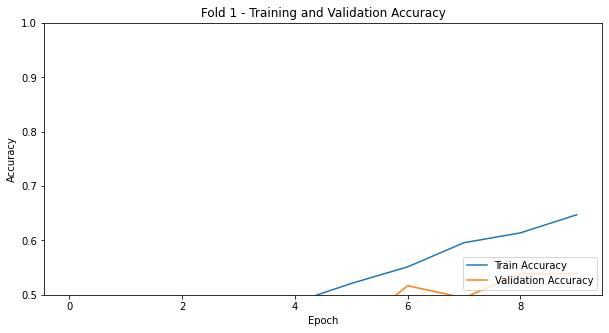

6/6 [==============================] - 2s 278ms/step - loss: 1.1099 - accuracy: 0.5278
Validation Accuracy for fold 1: 52.78%


accuracy,▁▃▃▅▅▆▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▃▂▂▁
val_accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▇▆▅▄▃▄▂▂▁
accuracy,0.64722
best_epoch,9
best_val_loss,1.12737
epoch,9
loss,0.89072
val_accuracy,0.53889


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 2 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/10
23/23 [==============================] - 11s 427ms/step - loss: 1.7828 - accuracy: 0.3111 - val_loss: 1.5965 - val_accuracy: 0.3389
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224903-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224903-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 2/10
23/23 [==============================] - 10s 406ms/step - loss: 1.4606 - accuracy: 0.3792 - val_loss: 1.4178 - val_accuracy: 0.4278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224903-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224903-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 3/10
23/23 [==============================] - 10s 417ms/step - loss: 1.2926 - accuracy: 0.4514 - val_loss: 1.3587 - val_accuracy: 0.4556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224903-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224903-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 4/10
23/23 [==============================] - 10s 414ms/step - loss: 1.2778 - accuracy: 0.4875 - val_loss: 1.2926 - val_accuracy: 0.5000
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224903-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224903-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 5/10
23/23 [==============================] - 10s 421ms/step - loss: 1.1528 - accuracy: 0.5347 - val_loss: 1.3069 - val_accuracy: 0.5167
Epoch 6/10
23/23 [==============================] - 10s 422ms/step - loss: 1.0587 - accuracy: 0.6028 - val_loss: 1.2182 - val_accuracy: 0.5278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224903-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224903-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 7/10
23/23 [==============================] - 10s 408ms/step - loss: 0.9955 - accuracy: 0.6111 - val_loss: 1.2587 - val_accuracy: 0.5167
Epoch 8/10
23/23 [==============================] - 10s 414ms/step - loss: 0.9285 - accuracy: 0.6417 - val_loss: 1.2006 - val_accuracy: 0.5444
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224903-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224903-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 9/10
23/23 [==============================] - 10s 405ms/step - loss: 0.8326 - accuracy: 0.6972 - val_loss: 1.1444 - val_accuracy: 0.6000
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224903-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224903-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 10/10
23/23 [==============================] - 10s 409ms/step - loss: 0.8343 - accuracy: 0.7000 - val_loss: 1.0541 - val_accuracy: 0.5667
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_224903-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_224903-2gd73ih2/files/model-best)... Done. 0.0s


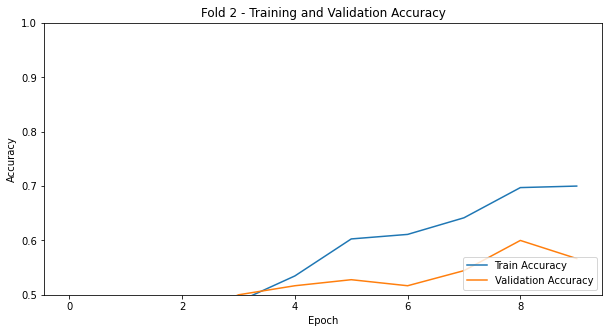

6/6 [==============================] - 2s 295ms/step - loss: 1.0868 - accuracy: 0.5500
Validation Accuracy for fold 2: 55.00%


accuracy,▁▂▄▄▅▆▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▆▆▆▇█▇
val_loss,█▆▅▄▄▃▄▃▂▁
accuracy,0.7
best_epoch,9
best_val_loss,1.05411
epoch,9
loss,0.83426
val_accuracy,0.56667


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 3 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/10
23/23 [==============================] - 11s 438ms/step - loss: 1.9008 - accuracy: 0.2736 - val_loss: 1.5771 - val_accuracy: 0.3500
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225104-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225104-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 2/10
23/23 [==============================] - 10s 408ms/step - loss: 1.5259 - accuracy: 0.3417 - val_loss: 1.3634 - val_accuracy: 0.4667
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225104-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225104-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 3/10
23/23 [==============================] - 10s 412ms/step - loss: 1.4260 - accuracy: 0.4111 - val_loss: 1.2995 - val_accuracy: 0.4222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225104-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225104-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 4/10
23/23 [==============================] - 10s 422ms/step - loss: 1.3009 - accuracy: 0.4750 - val_loss: 1.3163 - val_accuracy: 0.4444
Epoch 5/10
23/23 [==============================] - 10s 425ms/step - loss: 1.3218 - accuracy: 0.4875 - val_loss: 1.3051 - val_accuracy: 0.4778
Epoch 6/10
23/23 [==============================] - 10s 412ms/step - loss: 1.2513 - accuracy: 0.5097 - val_loss: 1.2554 - val_accuracy: 0.5056
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225104-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225104-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 7/10
23/23 [==============================] - 10s 413ms/step - loss: 1.1239 - accuracy: 0.5764 - val_loss: 1.0669 - val_accuracy: 0.5111
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225104-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225104-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 8/10
23/23 [==============================] - 10s 419ms/step - loss: 1.0564 - accuracy: 0.5778 - val_loss: 1.0855 - val_accuracy: 0.5500
Epoch 9/10
23/23 [==============================] - 10s 413ms/step - loss: 0.9986 - accuracy: 0.6097 - val_loss: 1.0319 - val_accuracy: 0.6000
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225104-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225104-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 10/10
23/23 [==============================] - 10s 415ms/step - loss: 0.9227 - accuracy: 0.6500 - val_loss: 0.9345 - val_accuracy: 0.6333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225104-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225104-2gd73ih2/files/model-best)... Done. 0.0s


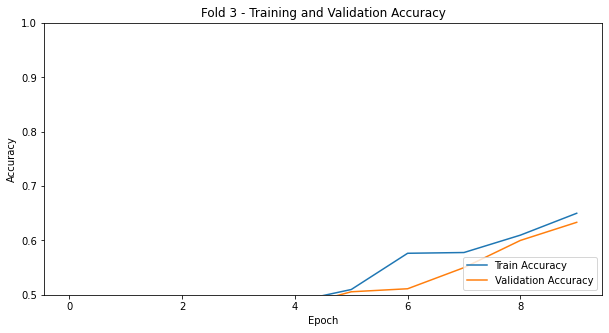

6/6 [==============================] - 2s 297ms/step - loss: 0.9921 - accuracy: 0.6500
Validation Accuracy for fold 3: 65.00%


accuracy,▁▂▄▅▅▅▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▅▄▄▃▂▂▂▁
val_accuracy,▁▄▃▃▄▅▅▆▇█
val_loss,█▆▅▅▅▄▂▃▂▁
accuracy,0.65
best_epoch,9
best_val_loss,0.93454
epoch,9
loss,0.92268
val_accuracy,0.63333


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 4 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/10
23/23 [==============================] - 11s 438ms/step - loss: 1.8646 - accuracy: 0.2542 - val_loss: 1.6116 - val_accuracy: 0.2722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 2/10
23/23 [==============================] - 10s 416ms/step - loss: 1.5109 - accuracy: 0.3833 - val_loss: 1.4611 - val_accuracy: 0.4333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 3/10
23/23 [==============================] - 10s 409ms/step - loss: 1.3932 - accuracy: 0.4153 - val_loss: 1.4107 - val_accuracy: 0.4444
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 4/10
23/23 [==============================] - 10s 407ms/step - loss: 1.2806 - accuracy: 0.4750 - val_loss: 1.2160 - val_accuracy: 0.5333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 5/10
23/23 [==============================] - 10s 414ms/step - loss: 1.1907 - accuracy: 0.5347 - val_loss: 1.2155 - val_accuracy: 0.5222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 6/10
23/23 [==============================] - 9s 401ms/step - loss: 1.1408 - accuracy: 0.5722 - val_loss: 1.0949 - val_accuracy: 0.5389
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 7/10
23/23 [==============================] - 9s 404ms/step - loss: 1.0011 - accuracy: 0.6375 - val_loss: 1.0635 - val_accuracy: 0.5778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 8/10
23/23 [==============================] - 10s 409ms/step - loss: 1.0189 - accuracy: 0.6042 - val_loss: 0.9620 - val_accuracy: 0.6222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 9/10
23/23 [==============================] - 10s 410ms/step - loss: 0.9194 - accuracy: 0.6417 - val_loss: 1.0063 - val_accuracy: 0.6222
Epoch 10/10
23/23 [==============================] - 10s 420ms/step - loss: 0.8127 - accuracy: 0.6944 - val_loss: 0.8212 - val_accuracy: 0.7278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225305-2gd73ih2/files/model-best)... Done. 0.0s


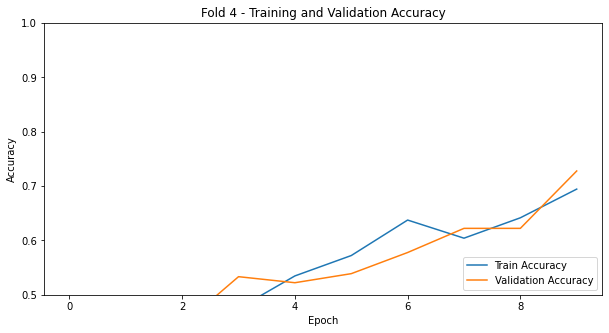

6/6 [==============================] - 2s 283ms/step - loss: 0.8399 - accuracy: 0.7056
Validation Accuracy for fold 4: 70.56%


accuracy,▁▃▄▅▅▆▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▄▃▂▂▂▁
val_accuracy,▁▃▄▅▅▅▆▆▆█
val_loss,█▇▆▄▄▃▃▂▃▁
accuracy,0.69444
best_epoch,9
best_val_loss,0.8212
epoch,9
loss,0.81269
val_accuracy,0.72778


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 5 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/10
23/23 [==============================] - 11s 423ms/step - loss: 1.8704 - accuracy: 0.2403 - val_loss: 1.6717 - val_accuracy: 0.2722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225508-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225508-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 2/10
23/23 [==============================] - 9s 398ms/step - loss: 1.5297 - accuracy: 0.3625 - val_loss: 1.6570 - val_accuracy: 0.3556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225508-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225508-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 3/10
23/23 [==============================] - 10s 407ms/step - loss: 1.3872 - accuracy: 0.4486 - val_loss: 1.4150 - val_accuracy: 0.4222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225508-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225508-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 4/10
23/23 [==============================] - 10s 408ms/step - loss: 1.2710 - accuracy: 0.4806 - val_loss: 1.2232 - val_accuracy: 0.5500
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225508-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225508-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 5/10
23/23 [==============================] - 10s 418ms/step - loss: 1.1744 - accuracy: 0.5444 - val_loss: 1.4205 - val_accuracy: 0.4556
Epoch 6/10
23/23 [==============================] - 10s 410ms/step - loss: 1.1681 - accuracy: 0.5403 - val_loss: 1.2010 - val_accuracy: 0.5667
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225508-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225508-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 7/10
23/23 [==============================] - 9s 404ms/step - loss: 1.0785 - accuracy: 0.5750 - val_loss: 1.1585 - val_accuracy: 0.5222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225508-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225508-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 8/10
23/23 [==============================] - 9s 397ms/step - loss: 0.9924 - accuracy: 0.6264 - val_loss: 1.0602 - val_accuracy: 0.5944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225508-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225508-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 9/10
23/23 [==============================] - 10s 409ms/step - loss: 0.9021 - accuracy: 0.6736 - val_loss: 0.9798 - val_accuracy: 0.6111
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225508-2gd73ih2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225508-2gd73ih2/files/model-best)... Done. 0.0s


Epoch 10/10
23/23 [==============================] - 10s 408ms/step - loss: 0.8142 - accuracy: 0.7125 - val_loss: 1.0230 - val_accuracy: 0.6000


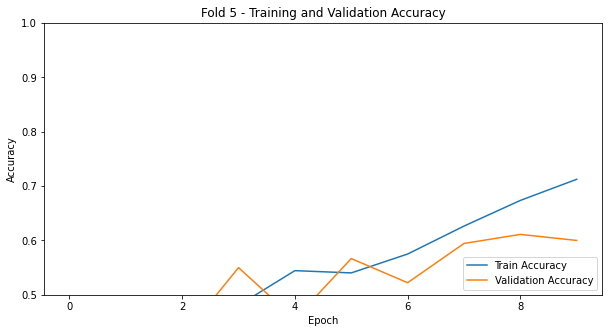

6/6 [==============================] - 2s 286ms/step - loss: 0.9632 - accuracy: 0.6389
Validation Accuracy for fold 5: 63.89%


accuracy,▁▃▄▅▆▅▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▃▂▂▁
val_accuracy,▁▃▄▇▅▇▆███
val_loss,██▅▃▅▃▃▂▁▁
accuracy,0.7125
best_epoch,8
best_val_loss,0.9798
epoch,9
loss,0.81418
val_accuracy,0.6


wandb: Agent Starting Run: 1ckaio4v with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.019767457346424547


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/5
23/23 [==============================] - 11s 433ms/step - loss: 1.9569 - accuracy: 0.2125 - val_loss: 1.7368 - val_accuracy: 0.2833
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225715-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225715-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 2/5
23/23 [==============================] - 10s 407ms/step - loss: 1.6794 - accuracy: 0.3139 - val_loss: 1.6018 - val_accuracy: 0.2944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225715-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225715-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 3/5
23/23 [==============================] - 10s 411ms/step - loss: 1.5156 - accuracy: 0.3694 - val_loss: 1.5414 - val_accuracy: 0.3778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225715-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225715-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 4/5
23/23 [==============================] - 10s 421ms/step - loss: 1.4003 - accuracy: 0.4097 - val_loss: 1.3687 - val_accuracy: 0.4167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225715-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225715-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 5/5
23/23 [==============================] - 10s 411ms/step - loss: 1.2604 - accuracy: 0.4931 - val_loss: 1.3378 - val_accuracy: 0.4944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225715-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225715-1ckaio4v/files/model-best)... Done. 0.0s


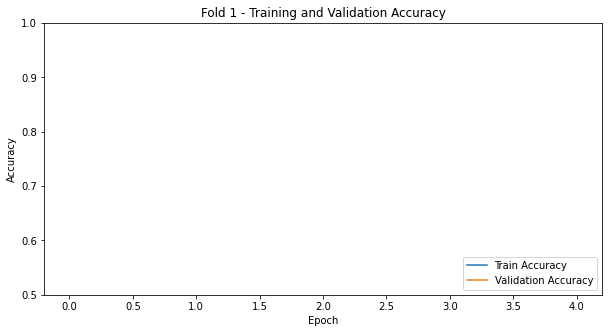

6/6 [==============================] - 2s 295ms/step - loss: 1.3075 - accuracy: 0.5056
Validation Accuracy for fold 1: 50.56%


accuracy,▁▄▅▆█
epoch,▁▃▅▆█
loss,█▅▄▂▁
val_accuracy,▁▁▄▅█
val_loss,█▆▅▂▁
accuracy,0.49306
best_epoch,4
best_val_loss,1.33781
epoch,4
loss,1.26041
val_accuracy,0.49444


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 2 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/5
23/23 [==============================] - 11s 428ms/step - loss: 1.9260 - accuracy: 0.2167 - val_loss: 1.6305 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225827-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225827-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 2/5
23/23 [==============================] - 10s 410ms/step - loss: 1.5391 - accuracy: 0.3486 - val_loss: 1.4432 - val_accuracy: 0.4222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225827-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225827-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 3/5
23/23 [==============================] - 10s 409ms/step - loss: 1.4207 - accuracy: 0.4014 - val_loss: 1.3995 - val_accuracy: 0.4556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225827-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225827-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 4/5
23/23 [==============================] - 9s 405ms/step - loss: 1.2719 - accuracy: 0.4972 - val_loss: 1.4111 - val_accuracy: 0.4333
Epoch 5/5
23/23 [==============================] - 9s 408ms/step - loss: 1.2241 - accuracy: 0.5153 - val_loss: 1.3756 - val_accuracy: 0.4833
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225827-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225827-1ckaio4v/files/model-best)... Done. 0.0s


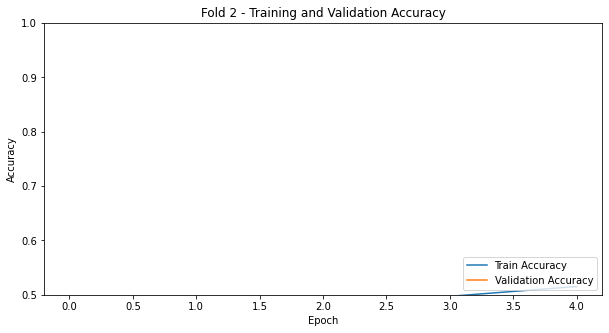

6/6 [==============================] - 2s 291ms/step - loss: 1.3170 - accuracy: 0.4889
Validation Accuracy for fold 2: 48.89%


accuracy,▁▄▅██
epoch,▁▃▅▆█
loss,█▄▃▁▁
val_accuracy,▁▅▇▆█
val_loss,█▃▂▂▁
accuracy,0.51528
best_epoch,4
best_val_loss,1.37556
epoch,4
loss,1.22408
val_accuracy,0.48333


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 3 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/5
23/23 [==============================] - 11s 433ms/step - loss: 1.7553 - accuracy: 0.3028 - val_loss: 1.4388 - val_accuracy: 0.4556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225932-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225932-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 2/5
23/23 [==============================] - 10s 404ms/step - loss: 1.4375 - accuracy: 0.4222 - val_loss: 1.3697 - val_accuracy: 0.4556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225932-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225932-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 3/5
23/23 [==============================] - 10s 423ms/step - loss: 1.3099 - accuracy: 0.4750 - val_loss: 1.1966 - val_accuracy: 0.5167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225932-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225932-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 4/5
23/23 [==============================] - 10s 414ms/step - loss: 1.1420 - accuracy: 0.5333 - val_loss: 1.1587 - val_accuracy: 0.5333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225932-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225932-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 5/5
23/23 [==============================] - 10s 411ms/step - loss: 1.0734 - accuracy: 0.5792 - val_loss: 1.0944 - val_accuracy: 0.5611
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_225932-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_225932-1ckaio4v/files/model-best)... Done. 0.0s


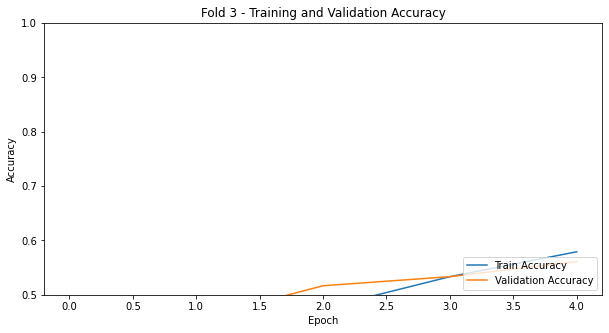

6/6 [==============================] - 2s 297ms/step - loss: 1.0845 - accuracy: 0.5611
Validation Accuracy for fold 3: 56.11%


accuracy,▁▄▅▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▁▅▆█
val_loss,█▇▃▂▁
accuracy,0.57917
best_epoch,4
best_val_loss,1.09444
epoch,4
loss,1.07336
val_accuracy,0.56111


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 4 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/5
23/23 [==============================] - 11s 424ms/step - loss: 1.8572 - accuracy: 0.2833 - val_loss: 1.7220 - val_accuracy: 0.2722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230040-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230040-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 2/5
23/23 [==============================] - 10s 412ms/step - loss: 1.5285 - accuracy: 0.3681 - val_loss: 1.4672 - val_accuracy: 0.3778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230040-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230040-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 3/5
23/23 [==============================] - 9s 405ms/step - loss: 1.3765 - accuracy: 0.4500 - val_loss: 1.3357 - val_accuracy: 0.4778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230040-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230040-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 4/5
23/23 [==============================] - 10s 409ms/step - loss: 1.3065 - accuracy: 0.4514 - val_loss: 1.3193 - val_accuracy: 0.4778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230040-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230040-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 5/5
23/23 [==============================] - 10s 406ms/step - loss: 1.2002 - accuracy: 0.5208 - val_loss: 1.3133 - val_accuracy: 0.4778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230040-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230040-1ckaio4v/files/model-best)... Done. 0.0s


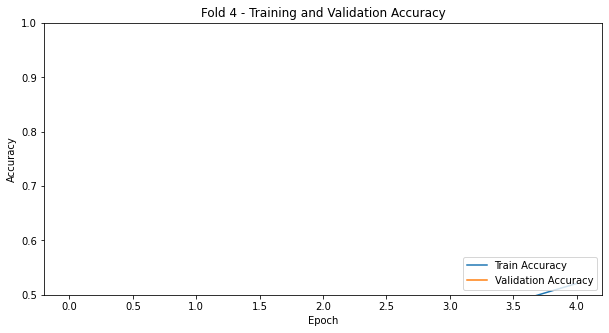

6/6 [==============================] - 2s 287ms/step - loss: 1.2553 - accuracy: 0.4722
Validation Accuracy for fold 4: 47.22%


accuracy,▁▃▆▆█
epoch,▁▃▅▆█
loss,█▄▃▂▁
val_accuracy,▁▅███
val_loss,█▄▁▁▁
accuracy,0.52083
best_epoch,4
best_val_loss,1.31326
epoch,4
loss,1.20015
val_accuracy,0.47778


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 5 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/5
23/23 [==============================] - 11s 432ms/step - loss: 1.8539 - accuracy: 0.2292 - val_loss: 1.6399 - val_accuracy: 0.2944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230148-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230148-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 2/5
23/23 [==============================] - 10s 407ms/step - loss: 1.5409 - accuracy: 0.3694 - val_loss: 1.5341 - val_accuracy: 0.3722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230148-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230148-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 3/5
23/23 [==============================] - 10s 409ms/step - loss: 1.3899 - accuracy: 0.4278 - val_loss: 1.3954 - val_accuracy: 0.4111
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230148-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230148-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 4/5
23/23 [==============================] - 9s 414ms/step - loss: 1.2917 - accuracy: 0.4653 - val_loss: 1.2513 - val_accuracy: 0.4556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230148-1ckaio4v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230148-1ckaio4v/files/model-best)... Done. 0.0s


Epoch 5/5
23/23 [==============================] - 10s 412ms/step - loss: 1.2392 - accuracy: 0.5417 - val_loss: 1.3165 - val_accuracy: 0.4444


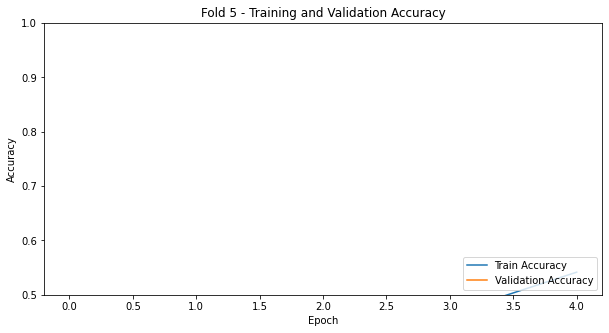

6/6 [==============================] - 2s 295ms/step - loss: 1.2874 - accuracy: 0.4778
Validation Accuracy for fold 5: 47.78%


accuracy,▁▄▅▆█
epoch,▁▃▅▆█
loss,█▄▃▂▁
val_accuracy,▁▄▆██
val_loss,█▆▄▁▂
accuracy,0.54167
best_epoch,3
best_val_loss,1.25134
epoch,4
loss,1.23915
val_accuracy,0.44444


wandb: Agent Starting Run: nhk3h7ou with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.03393366110117873


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/10
23/23 [==============================] - 11s 433ms/step - loss: 1.9223 - accuracy: 0.2444 - val_loss: 1.7302 - val_accuracy: 0.2333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 2/10
23/23 [==============================] - 10s 409ms/step - loss: 1.6185 - accuracy: 0.3097 - val_loss: 1.6212 - val_accuracy: 0.3222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 3/10
23/23 [==============================] - 9s 403ms/step - loss: 1.4416 - accuracy: 0.3903 - val_loss: 1.5288 - val_accuracy: 0.3389
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 4/10
23/23 [==============================] - 10s 407ms/step - loss: 1.3768 - accuracy: 0.4542 - val_loss: 1.4348 - val_accuracy: 0.4167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 5/10
23/23 [==============================] - 10s 415ms/step - loss: 1.3004 - accuracy: 0.4958 - val_loss: 1.3634 - val_accuracy: 0.4278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 6/10
23/23 [==============================] - 10s 412ms/step - loss: 1.1774 - accuracy: 0.5528 - val_loss: 1.3179 - val_accuracy: 0.4444
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 7/10
23/23 [==============================] - 10s 408ms/step - loss: 1.0991 - accuracy: 0.5875 - val_loss: 1.2223 - val_accuracy: 0.5056
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 8/10
23/23 [==============================] - 9s 402ms/step - loss: 1.0189 - accuracy: 0.6069 - val_loss: 1.1849 - val_accuracy: 0.5722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 9/10
23/23 [==============================] - 10s 406ms/step - loss: 0.9902 - accuracy: 0.6139 - val_loss: 1.2094 - val_accuracy: 0.4944
Epoch 10/10
23/23 [==============================] - 10s 418ms/step - loss: 0.9024 - accuracy: 0.6306 - val_loss: 1.1090 - val_accuracy: 0.5500
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230300-nhk3h7ou/files/model-best)... Done. 0.0s


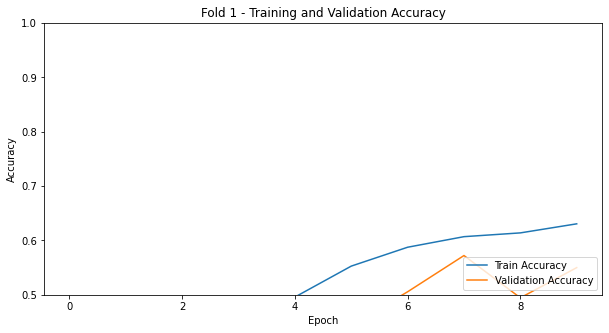

6/6 [==============================] - 2s 281ms/step - loss: 1.1020 - accuracy: 0.5444
Validation Accuracy for fold 1: 54.44%


accuracy,▁▂▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▄▃▂▂▂▁
val_accuracy,▁▃▃▅▅▅▇█▆█
val_loss,█▇▆▅▄▃▂▂▂▁
accuracy,0.63056
best_epoch,9
best_val_loss,1.10901
epoch,9
loss,0.90242
val_accuracy,0.55


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 2 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/10
23/23 [==============================] - 11s 439ms/step - loss: 1.8408 - accuracy: 0.2500 - val_loss: 1.6893 - val_accuracy: 0.2500
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 2/10
23/23 [==============================] - 9s 401ms/step - loss: 1.6200 - accuracy: 0.2875 - val_loss: 1.5060 - val_accuracy: 0.4000
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 3/10
23/23 [==============================] - 9s 403ms/step - loss: 1.4560 - accuracy: 0.4083 - val_loss: 1.4763 - val_accuracy: 0.3944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 4/10
23/23 [==============================] - 10s 405ms/step - loss: 1.2748 - accuracy: 0.4694 - val_loss: 1.3334 - val_accuracy: 0.4500
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 5/10
23/23 [==============================] - 10s 413ms/step - loss: 1.2002 - accuracy: 0.5167 - val_loss: 1.3922 - val_accuracy: 0.4667
Epoch 6/10
23/23 [==============================] - 10s 410ms/step - loss: 1.1524 - accuracy: 0.5306 - val_loss: 1.2832 - val_accuracy: 0.5000
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 7/10
23/23 [==============================] - 10s 405ms/step - loss: 1.0525 - accuracy: 0.5958 - val_loss: 1.1919 - val_accuracy: 0.5111
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 8/10
23/23 [==============================] - 9s 403ms/step - loss: 0.9802 - accuracy: 0.6083 - val_loss: 1.1912 - val_accuracy: 0.5278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 9/10
23/23 [==============================] - 9s 398ms/step - loss: 0.9034 - accuracy: 0.6625 - val_loss: 1.0612 - val_accuracy: 0.6000
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 10/10
23/23 [==============================] - 9s 404ms/step - loss: 0.8221 - accuracy: 0.6875 - val_loss: 1.0332 - val_accuracy: 0.6111
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230508-nhk3h7ou/files/model-best)... Done. 0.0s


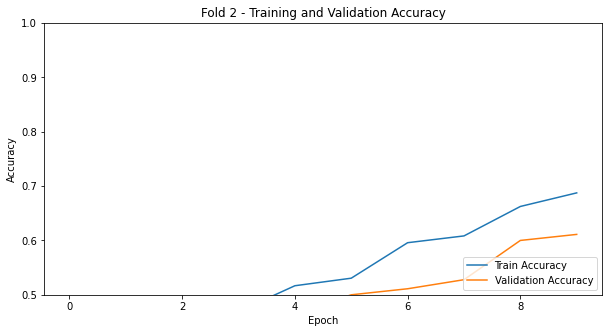

6/6 [==============================] - 2s 310ms/step - loss: 1.0817 - accuracy: 0.5667
Validation Accuracy for fold 2: 56.67%


accuracy,▁▂▄▅▅▅▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▄▄▅▅▆▆▆██
val_loss,█▆▆▄▅▄▃▃▁▁
accuracy,0.6875
best_epoch,9
best_val_loss,1.03318
epoch,9
loss,0.82213
val_accuracy,0.61111


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 3 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/10
23/23 [==============================] - 11s 425ms/step - loss: 1.8654 - accuracy: 0.2306 - val_loss: 1.7611 - val_accuracy: 0.2556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230709-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230709-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 2/10
23/23 [==============================] - 9s 401ms/step - loss: 1.6774 - accuracy: 0.2889 - val_loss: 1.6064 - val_accuracy: 0.2722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230709-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230709-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 3/10
23/23 [==============================] - 10s 410ms/step - loss: 1.5528 - accuracy: 0.3597 - val_loss: 1.4051 - val_accuracy: 0.4444
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230709-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230709-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 4/10
23/23 [==============================] - 9s 406ms/step - loss: 1.3989 - accuracy: 0.4208 - val_loss: 1.2935 - val_accuracy: 0.4444
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230709-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230709-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 5/10
23/23 [==============================] - 10s 414ms/step - loss: 1.3164 - accuracy: 0.4403 - val_loss: 1.1703 - val_accuracy: 0.5222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230709-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230709-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 6/10
23/23 [==============================] - 10s 407ms/step - loss: 1.2763 - accuracy: 0.4931 - val_loss: 1.2442 - val_accuracy: 0.4833
Epoch 7/10
23/23 [==============================] - 9s 408ms/step - loss: 1.1851 - accuracy: 0.5250 - val_loss: 1.1860 - val_accuracy: 0.5222
Epoch 8/10
23/23 [==============================] - 9s 407ms/step - loss: 1.0705 - accuracy: 0.5708 - val_loss: 1.0860 - val_accuracy: 0.5611
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230709-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230709-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 9/10
23/23 [==============================] - 10s 408ms/step - loss: 0.9837 - accuracy: 0.6111 - val_loss: 1.1454 - val_accuracy: 0.5556
Epoch 10/10
23/23 [==============================] - 10s 413ms/step - loss: 0.9530 - accuracy: 0.6194 - val_loss: 0.9640 - val_accuracy: 0.6111
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230709-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230709-nhk3h7ou/files/model-best)... Done. 0.0s


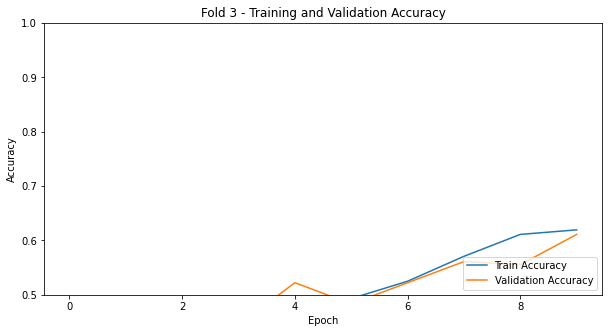

6/6 [==============================] - 2s 293ms/step - loss: 1.0160 - accuracy: 0.5778
Validation Accuracy for fold 3: 57.78%


accuracy,▁▂▃▄▅▆▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▄▄▃▃▂▁▁
val_accuracy,▁▁▅▅▆▅▆▇▇█
val_loss,█▇▅▄▃▃▃▂▃▁
accuracy,0.61944
best_epoch,9
best_val_loss,0.96403
epoch,9
loss,0.95296
val_accuracy,0.61111


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 4 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/10
23/23 [==============================] - 11s 431ms/step - loss: 1.8305 - accuracy: 0.2528 - val_loss: 1.6415 - val_accuracy: 0.2611
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230908-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230908-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 2/10
23/23 [==============================] - 9s 397ms/step - loss: 1.5489 - accuracy: 0.3708 - val_loss: 1.6852 - val_accuracy: 0.3056
Epoch 3/10
23/23 [==============================] - 9s 409ms/step - loss: 1.4487 - accuracy: 0.3903 - val_loss: 1.5638 - val_accuracy: 0.3611
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230908-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230908-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 4/10
23/23 [==============================] - 10s 407ms/step - loss: 1.2805 - accuracy: 0.5056 - val_loss: 1.3107 - val_accuracy: 0.4944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230908-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230908-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 5/10
23/23 [==============================] - 10s 418ms/step - loss: 1.2084 - accuracy: 0.5389 - val_loss: 1.3564 - val_accuracy: 0.4667
Epoch 6/10
23/23 [==============================] - 9s 406ms/step - loss: 1.0964 - accuracy: 0.5847 - val_loss: 1.0999 - val_accuracy: 0.5667
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230908-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230908-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 7/10
23/23 [==============================] - 9s 404ms/step - loss: 1.0649 - accuracy: 0.5708 - val_loss: 1.1203 - val_accuracy: 0.5833
Epoch 8/10
23/23 [==============================] - 9s 404ms/step - loss: 0.9873 - accuracy: 0.6181 - val_loss: 1.0529 - val_accuracy: 0.5944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230908-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230908-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 9/10
23/23 [==============================] - 9s 402ms/step - loss: 0.9180 - accuracy: 0.6597 - val_loss: 0.9085 - val_accuracy: 0.6556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230908-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230908-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 10/10
23/23 [==============================] - 10s 417ms/step - loss: 0.8408 - accuracy: 0.6903 - val_loss: 0.8778 - val_accuracy: 0.7000
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_230908-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_230908-nhk3h7ou/files/model-best)... Done. 0.0s


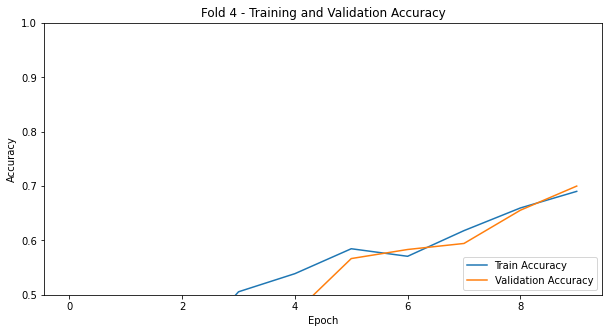

6/6 [==============================] - 2s 300ms/step - loss: 0.9653 - accuracy: 0.6444
Validation Accuracy for fold 4: 64.44%


accuracy,▁▃▃▅▆▆▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▂▃▅▄▆▆▆▇█
val_loss,██▇▅▅▃▃▃▁▁
accuracy,0.69028
best_epoch,9
best_val_loss,0.87776
epoch,9
loss,0.8408
val_accuracy,0.7


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 5 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/10
23/23 [==============================] - 11s 431ms/step - loss: 1.9796 - accuracy: 0.2111 - val_loss: 1.7972 - val_accuracy: 0.1722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231108-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231108-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 2/10
23/23 [==============================] - 10s 405ms/step - loss: 1.7642 - accuracy: 0.2431 - val_loss: 1.6801 - val_accuracy: 0.2889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231108-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231108-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 3/10
23/23 [==============================] - 10s 409ms/step - loss: 1.6345 - accuracy: 0.3097 - val_loss: 1.5874 - val_accuracy: 0.3278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231108-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231108-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 4/10
23/23 [==============================] - 10s 414ms/step - loss: 1.4568 - accuracy: 0.3903 - val_loss: 1.3697 - val_accuracy: 0.4167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231108-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231108-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 5/10
23/23 [==============================] - 10s 421ms/step - loss: 1.3706 - accuracy: 0.4264 - val_loss: 1.3384 - val_accuracy: 0.4500
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231108-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231108-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 6/10
23/23 [==============================] - 10s 410ms/step - loss: 1.2420 - accuracy: 0.4708 - val_loss: 1.3939 - val_accuracy: 0.4389
Epoch 7/10
23/23 [==============================] - 10s 418ms/step - loss: 1.1637 - accuracy: 0.5361 - val_loss: 1.2848 - val_accuracy: 0.5056
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231108-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231108-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 8/10
23/23 [==============================] - 10s 409ms/step - loss: 1.1403 - accuracy: 0.5347 - val_loss: 1.1304 - val_accuracy: 0.5778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231108-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231108-nhk3h7ou/files/model-best)... Done. 0.0s


Epoch 9/10
23/23 [==============================] - 10s 422ms/step - loss: 1.0697 - accuracy: 0.5764 - val_loss: 1.2109 - val_accuracy: 0.5111
Epoch 10/10
23/23 [==============================] - 9s 408ms/step - loss: 1.0275 - accuracy: 0.6056 - val_loss: 1.0542 - val_accuracy: 0.5556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231108-nhk3h7ou/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231108-nhk3h7ou/files/model-best)... Done. 0.0s


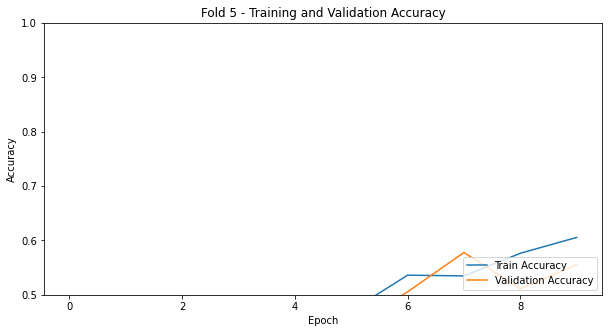

6/6 [==============================] - 2s 303ms/step - loss: 1.1108 - accuracy: 0.5333
Validation Accuracy for fold 5: 53.33%


accuracy,▁▂▃▄▅▆▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▃▄▅▆▆▇█▇█
val_loss,█▇▆▄▄▄▃▂▂▁
accuracy,0.60556
best_epoch,9
best_val_loss,1.0542
epoch,9
loss,1.02747
val_accuracy,0.55556


wandb: Agent Starting Run: nhxdw7jm with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.08938672499508155


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 442ms/step - loss: 1.8644 - accuracy: 0.2347 - val_loss: 1.6670 - val_accuracy: 0.2833
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231315-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231315-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 10s 417ms/step - loss: 1.6393 - accuracy: 0.2903 - val_loss: 1.5379 - val_accuracy: 0.3500
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231315-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231315-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 10s 410ms/step - loss: 1.5173 - accuracy: 0.3556 - val_loss: 1.5328 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231315-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231315-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 10s 422ms/step - loss: 1.3911 - accuracy: 0.4500 - val_loss: 1.4800 - val_accuracy: 0.3500
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231315-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231315-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 5/7
23/23 [==============================] - 10s 410ms/step - loss: 1.2778 - accuracy: 0.4986 - val_loss: 1.2976 - val_accuracy: 0.4556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231315-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231315-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 6/7
23/23 [==============================] - 10s 406ms/step - loss: 1.1786 - accuracy: 0.5389 - val_loss: 1.3999 - val_accuracy: 0.4389
Epoch 7/7
23/23 [==============================] - 10s 413ms/step - loss: 1.1234 - accuracy: 0.5722 - val_loss: 1.2719 - val_accuracy: 0.4833
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231315-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231315-nhxdw7jm/files/model-best)... Done. 0.0s


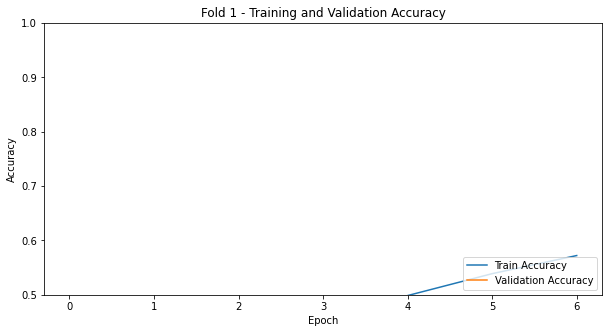

6/6 [==============================] - 2s 286ms/step - loss: 1.2423 - accuracy: 0.5167
Validation Accuracy for fold 1: 51.67%


accuracy,▁▂▄▅▆▇█
epoch,▁▂▃▅▆▇█
loss,█▆▅▄▂▂▁
val_accuracy,▁▃▃▃▇▆█
val_loss,█▆▆▅▁▃▁
accuracy,0.57222
best_epoch,6
best_val_loss,1.27193
epoch,6
loss,1.12342
val_accuracy,0.48333


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 2 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 435ms/step - loss: 1.9689 - accuracy: 0.1986 - val_loss: 1.7632 - val_accuracy: 0.2167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231448-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231448-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 10s 412ms/step - loss: 1.6209 - accuracy: 0.3000 - val_loss: 1.5246 - val_accuracy: 0.3667
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231448-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231448-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 10s 409ms/step - loss: 1.4608 - accuracy: 0.3569 - val_loss: 1.4210 - val_accuracy: 0.4222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231448-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231448-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 9s 394ms/step - loss: 1.3072 - accuracy: 0.4556 - val_loss: 1.2973 - val_accuracy: 0.4722
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231448-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231448-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 5/7
23/23 [==============================] - 9s 404ms/step - loss: 1.2431 - accuracy: 0.4833 - val_loss: 1.4356 - val_accuracy: 0.4056
Epoch 6/7
23/23 [==============================] - 9s 408ms/step - loss: 1.2283 - accuracy: 0.5139 - val_loss: 1.3159 - val_accuracy: 0.4833
Epoch 7/7
23/23 [==============================] - 10s 415ms/step - loss: 1.0827 - accuracy: 0.5764 - val_loss: 1.3075 - val_accuracy: 0.5056


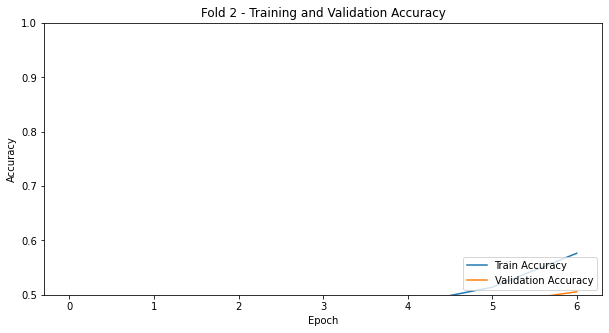

6/6 [==============================] - 2s 285ms/step - loss: 1.2940 - accuracy: 0.5333
Validation Accuracy for fold 2: 53.33%


accuracy,▁▃▄▆▆▇█
epoch,▁▂▃▅▆▇█
loss,█▅▄▃▂▂▁
val_accuracy,▁▅▆▇▆▇█
val_loss,█▄▃▁▃▁▁
accuracy,0.57639
best_epoch,3
best_val_loss,1.29731
epoch,6
loss,1.08275
val_accuracy,0.50556


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 3 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 423ms/step - loss: 1.8727 - accuracy: 0.2264 - val_loss: 1.6268 - val_accuracy: 0.3889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231615-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231615-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 9s 403ms/step - loss: 1.6312 - accuracy: 0.3167 - val_loss: 1.5356 - val_accuracy: 0.3556
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231615-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231615-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 10s 406ms/step - loss: 1.4873 - accuracy: 0.3778 - val_loss: 1.4490 - val_accuracy: 0.3778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231615-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231615-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 10s 413ms/step - loss: 1.3737 - accuracy: 0.4292 - val_loss: 1.2438 - val_accuracy: 0.4944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231615-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231615-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 5/7
23/23 [==============================] - 10s 408ms/step - loss: 1.2901 - accuracy: 0.4764 - val_loss: 1.3014 - val_accuracy: 0.4667
Epoch 6/7
23/23 [==============================] - 9s 406ms/step - loss: 1.1522 - accuracy: 0.5486 - val_loss: 1.0802 - val_accuracy: 0.5889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231615-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231615-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 7/7
23/23 [==============================] - 10s 405ms/step - loss: 1.0329 - accuracy: 0.5986 - val_loss: 1.0519 - val_accuracy: 0.5611
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231615-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231615-nhxdw7jm/files/model-best)... Done. 0.0s


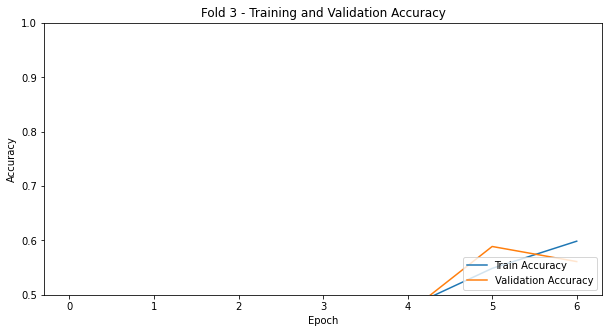

6/6 [==============================] - 2s 292ms/step - loss: 1.0462 - accuracy: 0.5444
Validation Accuracy for fold 3: 54.44%


accuracy,▁▃▄▅▆▇█
epoch,▁▂▃▅▆▇█
loss,█▆▅▄▃▂▁
val_accuracy,▂▁▂▅▄█▇
val_loss,█▇▆▃▄▁▁
accuracy,0.59861
best_epoch,6
best_val_loss,1.05195
epoch,6
loss,1.03292
val_accuracy,0.56111


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 4 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 426ms/step - loss: 1.8034 - accuracy: 0.2681 - val_loss: 1.6869 - val_accuracy: 0.3111
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231744-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231744-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 10s 416ms/step - loss: 1.4892 - accuracy: 0.3694 - val_loss: 1.4659 - val_accuracy: 0.3500
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231744-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231744-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 3/7
23/23 [==============================] - 10s 409ms/step - loss: 1.3772 - accuracy: 0.4125 - val_loss: 1.3926 - val_accuracy: 0.4222
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231744-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231744-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 9s 401ms/step - loss: 1.3603 - accuracy: 0.4389 - val_loss: 1.2123 - val_accuracy: 0.5278
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231744-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231744-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 5/7
23/23 [==============================] - 9s 403ms/step - loss: 1.2060 - accuracy: 0.5042 - val_loss: 1.1460 - val_accuracy: 0.4944
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231744-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231744-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 6/7
23/23 [==============================] - 10s 407ms/step - loss: 1.1665 - accuracy: 0.5389 - val_loss: 1.1346 - val_accuracy: 0.5667
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231744-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231744-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 7/7
23/23 [==============================] - 10s 407ms/step - loss: 1.0675 - accuracy: 0.5847 - val_loss: 1.1623 - val_accuracy: 0.5833


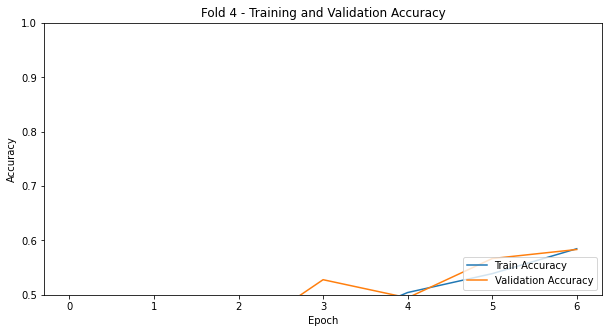

6/6 [==============================] - 2s 297ms/step - loss: 1.1668 - accuracy: 0.5556
Validation Accuracy for fold 4: 55.56%


accuracy,▁▃▄▅▆▇█
epoch,▁▂▃▅▆▇█
loss,█▅▄▄▂▂▁
val_accuracy,▁▂▄▇▆██
val_loss,█▅▄▂▁▁▁
accuracy,0.58472
best_epoch,5
best_val_loss,1.13462
epoch,6
loss,1.06747
val_accuracy,0.58333


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 5 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.


Epoch 1/7
23/23 [==============================] - 11s 429ms/step - loss: 1.9021 - accuracy: 0.2319 - val_loss: 1.6546 - val_accuracy: 0.3167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231913-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231913-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 2/7
23/23 [==============================] - 9s 401ms/step - loss: 1.6263 - accuracy: 0.3083 - val_loss: 1.6617 - val_accuracy: 0.3000
Epoch 3/7
23/23 [==============================] - 10s 410ms/step - loss: 1.4934 - accuracy: 0.3861 - val_loss: 1.5329 - val_accuracy: 0.4167
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231913-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231913-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 4/7
23/23 [==============================] - 10s 406ms/step - loss: 1.4113 - accuracy: 0.4375 - val_loss: 1.5490 - val_accuracy: 0.3278
Epoch 5/7
23/23 [==============================] - 10s 409ms/step - loss: 1.3042 - accuracy: 0.4944 - val_loss: 1.3243 - val_accuracy: 0.4889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231913-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231913-nhxdw7jm/files/model-best)... Done. 0.0s


Epoch 6/7
23/23 [==============================] - 10s 409ms/step - loss: 1.2189 - accuracy: 0.5222 - val_loss: 1.3602 - val_accuracy: 0.4667
Epoch 7/7
23/23 [==============================] - 9s 404ms/step - loss: 1.1022 - accuracy: 0.5569 - val_loss: 1.1637 - val_accuracy: 0.5500
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20241116_231913-nhxdw7jm/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20241116_231913-nhxdw7jm/files/model-best)... Done. 0.0s


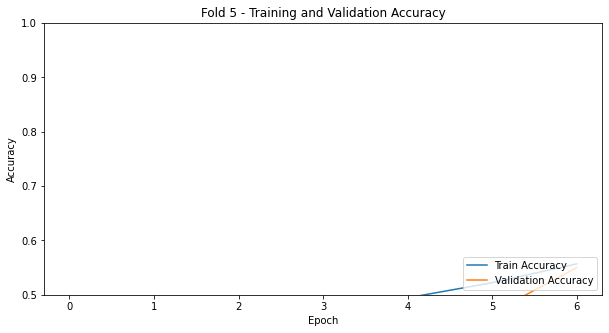

6/6 [==============================] - 2s 293ms/step - loss: 1.2304 - accuracy: 0.5111
Validation Accuracy for fold 5: 51.11%


accuracy,▁▃▄▅▇▇█
epoch,▁▂▃▅▆▇█
loss,█▆▄▄▃▂▁
val_accuracy,▁▁▄▂▆▆█
val_loss,██▆▆▃▄▁
accuracy,0.55694
best_epoch,6
best_val_loss,1.16369
epoch,6
loss,1.1022
val_accuracy,0.55


In [142]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = "wisdom-jihyekim-aiffel",
                       project = "WandB_with_kfold_used_by_Jindeok")

# run the sweep
wandb.agent(sweep_id,
            function=train_with_kfold,
            count=10)

In [143]:
print(f"Mean CV Accuracy: {np.mean(cvScores):.2f}% ± {np.std(cvScores):.2f}%")

Mean CV Accuracy: 46.11% ± 4.17%


In [144]:
avgScores = np.mean(cvScores)
stdScores = np.std(cvScores)
print(f"Average KFold Cross Validation Score: {avgScores}")
print(f"Standard Deviation KFold Cross Validation Score: {stdScores}")

Average KFold Cross Validation Score: 46.11111044883728
Standard Deviation KFold Cross Validation Score: 4.172217957296595
